# **FINAL PROJECT (BETA GROUP) - HOTEL BOOKING DEMAND**

**Created by:**

- Azhar Muhammad Fikri Fuadi (JCDS - 0208-008)
- Chasanah Nur Ikayanti (JCDS - 0208-006)
- Muhammad Zulfiqar (JCDS - 0208-013)

**Contents:**

- Business Problem Understanding
- Data Understanding
- Exploratory Data Analysis
- Preprocessing
- Methodology (Analysis / Modeling)
- Conclusion and Recommendation
- Save Model

In [160]:
# algorithm
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# preprocessing
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# metrics
from sklearn.metrics import f1_score, precision_score, recall_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# statistics
from scipy.stats import normaltest

# data visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# miscellaneous
from termcolor import colored

# data manipulation
import pandas as pd
import numpy as np

# warning handling
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.filterwarnings("ignore")

# saving model
import pickle

# membuat shap
import shap

# maximizing columns and columns width
pd.set_option("display.max_colwidth", 1)
pd.set_option('display.max_columns', None)

## **BUSINESS PROBLEM UNDERSTANDING**

**Context:**

Pembatalan pemesanan merupakan aspek kunci dari manajemen pendapatan hotel karena mempengaruhi sistem reservasi kamar. Pembatalan dalam reservasi pemesanan hotel dapat mengakibatkan kerugian bagi pihak hotel terhadap keputusan manajemen permintaan industri hotel. Banyak faktor yang menyebabkan pembatalan pemesanan seperti jadwal perjalanan bisnis, hari libur, lingkungan yang buruk (pandemi) dan faktor lainnya. Memahami alasan pembatalan pemesanan pelanggan merupakan aspek penting bagi pihak hotel. Mengidentifikasi faktor-faktor yang menyebabkan pembatalan pemesanan dapat membantu hotel mengatasi masalah, meningkatkan kepuasan pelanggan, dan menerapkan strategi untuk meminimalkan pembatalan. Hal ini dapat dilakukan pihak hotel untuk menyesuaikan layanan dan penawarannya agar memenuhi ekpetasi keinginan pelanggan. 

Namun hal ini menjadi tantangan untuk memprediksi faktor pembatalan pemesanan. Untuk mengurangi pembatalan reservasi, akan sangat membantu bagi hotel memiliki sistem yang dapat memprediksi apakah suatu pemesanan akan dibatalkan sehingga mereka dapat menawarkan kamar kepada pelanggan lain atau membuat rencana lainnya. Dalam industri perhotelan terdapat standard format yang bernama Passenger Name Record (PNR) yang dikembangkan oleh industri pariwisata dan perjalanan yang digunakan sebagai pengembangan model prediksi untuk mengklasifikasikan kemungkinan pembatalan pemesanan hotel.

**Problem Statement:**

LisGarve City & Resort Hotel adalah sebuah penginapan yang berada di Portugal. Saat ini mengalami penurunan pendapatan karena banyak mengalami pembatalan pemesanan yang menyebabkan kerugian bagi pihak hotel. Mereka ingin mengetahui tindakan yang harus diambil oleh pihak manajemen hotel untuk mengurangi peluang terjadinya pembatalan pemesanan dengan mengidentifikasi karakteristik yang dimiliki oleh hotel. Banyak faktor yang menyebabkan pembatalan hotel, namun sulit untuk pihak hotel untuk melakukan tracking alasan calon konsumen melakukan pembatalan pemesanan. Sehingga pihak hotel memerlukan kemampuan untuk memprediksi calon konsumen mana yang berpeluang membatalkan pemesanan hotel.

**Goals:**

Berdasarkan permasalahan yang telah dipaparkan, pihak hotel ingin megetahui karakteristik konsumen yang berpeluang membatalkan pemesanan hotel. Untuk meningkatkan pendapatan hotel, tim marketing hotel ingin membuat program yang lebih tepat sasaran kepada calon konsumen yang berpeluang melakukan pembatalan pemesanan.

**Analytic Approach:**

Pendekatan analisis dilakukan beberapa tahapan proses seperti pengumpulan data yang komprehensif, melakukan data cleaning, dan melakukan pengolahan data untuk mendapatkan hasil analisis. Dengan data ini untuk mendapatkan hasil analisis yang akan digunakan untuk pengambilan keputusan, kami melakukan pengolahan data dengan menggunakan pemodelan machine learning untuk memprediksi calon konsumen berpeluang melakukan pembatalan pemesanan hotel atau tidak. 

**Metric Evaluation:**

![alt text](https://www.researchgate.net/publication/328148379/figure/fig1/AS:679514740895744@1539020347601/Model-performance-metrics-Visual-representation-of-the-classification-model-metrics.png)


- *(TP) True Positive*: Pelanggan diprediksi (predict) cancel dan aktualnya (actual) benar-benar cancel.
- *(FP) False Positive*: Pelanggan diprediksi (predict) cancel, tetapi sebenarnya (actual) tidak cancel.
- *(FN) False Negative*: Pelanggan diprediksi (predict) TIDAK cancel, tetapi sebenarnya (actual) cancel.
- *(TN) True Negative*: Pelanggan diprediksi (predict) TIDAK cancel dan sebenarnya (actual) TIDAK cancel.

Untuk megetahui performa suatu model memprediksi targetnya maka kita membutuhkan metric evaluation dengan mengukur nilai errornya. Karena fokus utama kita ingin mengurangi kerugian yang diakibatkan dari pemesanan hotel yang aktualnya cancel namun diprediksi tidak cancel (False Negative). Mengapa Nilai False Negative menjadi fokus pada pemodelan? Karena dari segi bisnis lebih merugikan apabila dilihat dari konsekuensi yang harus ditanggung oleh pihak hotel. Pada percobaan ini kita menggunakan identifikasi sebagai berikut :

Target :
- 0 : Not Canceled
- 1 : Canceled

Action pihak hotel terhadap hasil prediksi:
Cancel : melakukan pendekatan terhadap customer yang diprediksi cancel dengan memberikan voucher senilai 10%

Type 1 Error : False Positif (Pelanggan yang aktualnya tidak cancel tetapi diprediksi cancel)
<br>
Konsekuensi :  Pihak hotel harus menanggung biaya voucher sebesar 10% dari harga hotel.

Type 2 Error : False Negative (Pelanggan yang aktualnya cancel tetapi diprediksi tidak cancel)
<br>
Konsekuensi : Pihak hotel harus kehilangan kesempatan untuk mendapat benefit sejumlah harga kamar hotel.

Untuk memberikan gambaran konsekuensi secara kuantitatif, maka kita akan coba hitung dampak biaya berdasarkan asumsi berikut :
- Rata-rata harga hotel per malam di portugal : 91.85 Euro
- Rata-rata persentase voucher gift hotel : 10% x harga hotel per malam = 10% x 91.85 = 9.1 Euro  


Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi customer yang melakukan cancel dari hotel tersebut, khususnya jumlah False Negative (pelanggan yang aktualnya cancel tetapi diprediksi tidak akan cancel). Jadi nanti metric utama yang akan kita gunakan adalah recall, karena biaya yang akan ditanggung hotel akan lebih besar (kehilangan kesempatan seharga satu kamar/malam)

## **DATA UNDERSTANDING**

Sebelum masuk ke dalam tahap *Exploratory Data Analysis* (EDA), kita perlu mengenali *dataset*-nya terlebih dahulu pada tahap *data understanding*. *Dataset* dengan tema *Hotel Booking Demand* ini berasal dari sebuah [artikel](https://www.sciencedirect.com/science/article/pii/S2352340918315191) yang ditulis oleh Nuno Antonio, Ana Almeida, dan Luis Nunes dalam jurnal *Data in Brief* pada tahun 2019. *Dataset* ini mulanya berjumlah 2 buah *dataset* terkait data *hotel demand* yang terdiri dari *dataset* salah satu *City Hotel* di Lisbon serta *dataset* salah satu *Resort Hotel* di Algarve (kedua hotel terletak di Portugal), yang telah digabungkan menjadi 1 buah *dataset*. Kedua *dataset* tersebut mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, serta memiliki struktur yang sama, yaitu dengan 32 kolom dan setiap barisnya merepresentasikan pemesanan hotel. Di karenakan *dataset* ini merupakan data hotel yang riil, semua elemen yang berkaitan dengan identitas hotel atau pemesan telah dihapus. Sumber dari *dataset* tersebut dapat diakses pada tautan [ini](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data), sedangkan deskripsi terkait semua *attribute*-nya dapat dilihat pada tabel berikut.

| Attribute | Data Type | Description |
| --- | --- | --- |
| `hotel` | String | Tipe hotel yang disediakan. |
| `is_canceled` | Integer | Nilai yang menunjukkan apakah *booking* hotel dibatalkan (1) atau tidak dibatalkan (0). |
| `lead_time` | Integer | Jarak hari antara tanggal *booking* hotel yang telah masuk ke dalam *Hotel Property Management System* (PMS) hingga tanggal yang dijadwalkan untuk *check-in*. |
| `arrival_date_year` | Integer | Tahun dari tanggal yang dijadwalkan untuk *check-in*. |
| `arrival_date_month` | String | Bulan dari tanggal yang dijadwalkan untuk *check-in*. |
| `arrival_date_week_number` | Integer | Urutan minggu dalam setahun dari tanggal yang dijadwalkan untuk *check-in*. |
| `arrival_date_day_of_month` | Integer | Tanggal yang dijadwalkan untuk *check-in*. |
| `stays_in_weekend_nights` | Integer | Jumlah malam di akhir pekan (Sabtu atau Minggu) yang di-*booking* oleh pemesan untuk menginap di hotel. |
| `stays_in_week_nights` | Integer | Jumlah malam dalam seminggu (Senin - Jum'at) yang di-*booking* oleh pemesan untuk menginap di hotel. |
| `adults` | Integer | Jumlah orang dewasa. |
| `children` | Float | Jumlah anak-anak. |
| `babies` | Integer | Jumlah bayi. |
| `meal` | String | Jenis makanan yang dipesan. Kategori disajikan dalam paket makanan standar perhotelan, yang mana *Undefined* atau SC berarti 'tidak memesan makanan'. |
| `country` | String | Negara asal pemesan. Kategori disajikan dalam format ISO 3166-3:2013 (sekarang [ISO 3166-3:2020](https://www.iso.org/standard/72484.html)). |
| `market_segment` | String | Pemilihan untuk segmentasi pasar (asumsi: segmentasi yang dibuat oleh pihak hotel). Dalam kategori, istilah "TA" ialah singkatan dari "Travel Agents", sedangkan "TO" ialah singkatan dari "Tour Operators". |
| `distribution_channel` | String | Saluran distribusi untuk setiap *booking* hotel. Dalam kategori, istilah "TA" ialah singkatan dari "Travel Agents", sedangkan "TO" ialah singkatan dari "Tour Operators". | |
| `is_repeated_guest` | Integer | Nilai yang menunjukkan apakah nama pemesan berasal dari pemesan yang berulang (1) atau tidak berulang (0). |
| `previous_cancellations` | Integer | Jumlah *booking* hotel sebelumnya yang dibatalkan oleh pemesan sebelum *booking* hotel terkini. Jika tidak ada profil pelanggan yang terkait dengan seluruh pemesanan, maka nilainya akan diatur ke 0. Sementara itu, jika ada profil pelanggan yang terkait dengan seluruh pemesanan, maka nilainya adalah jumlah seluruh pemesanan dengan profil sama yang dibuat sebelum pemesanan saat ini dan dibatalkan. |
| `previous_bookings_not_canceled` | Integer | Jumlah *booking* hotel sebelumnya yang tidak dibatalkan oleh pemesan sebelum *booking* hotel terkini. Jika tidak ada profil pelanggan yang terkait dengan seluruh pemesanan, maka nilainya akan diatur ke 0. Sementara itu, jika ada profil pelanggan yang terkait dengan seluruh pemesanan, maka nilainya adalah jumlah seluruh pemesanan dengan profil sama yang dibuat sebelum pemesanan saat ini dan tidak dibatalkan. |
| `reserved_room_type` | String | Kode untuk tipe kamar yang disediakan. Kode disajikan sebagai pengganti sebutan untuk alasan anonimitas. |
| `assigned_room_type` | String | Kode untuk tipe kamar yang ditetapkan untuk pemesanan. Terkadang tipe kamar yang ditetapkan berbeda dengan tipe kamar yang dipesan karena alasan operasional hotel (misalnya pemesanan berlebih), atau karena permintaan pelanggan. Kode disajikan sebagai pengganti sebutan untuk alasan anonimitas. |
| `booking_changes` | Integer | Jumlah perubahan yang dilakukan pada *booking* hotel sejak masuk ke dalam *Hotel Property Management System* (PMS) hingga saat *check-in* atau pembatalan. |
| `deposit_type` | String | Indikasi apakah pemesan melakukan deposit untuk menjamin *booking* hotel. Variabel ini hanya memiliki 3 kategori, pertama adalah *No Deposit* yang berarti 'tidak ada deposit yang dilakukan', kedua ialah *Non Refund* yang berarti 'deposit dilakukan senilai total biaya menginap', dan ketiga yaitu *Refundable* yang berarti 'deposit dilakukan dengan nilai di bawah total biaya menginap'. |
| `agent` | Float | ID dari *travel agency* yang melakukan *booking* hotel. |
| `company` | Float | ID dari perusahaan yang melakukan *booking* hotel atau yang bertanggung jawab untuk membayar *booking*-nya. ID ditampilkan sebagai pengganti sebutan untuk alasan anonimitas. |
| `days_in_waiting_list` | Integer | Jumlah hari untuk setiap *booking* hotel yang masuk ke dalam *waiting list* sebelum akhirnya dikonfirmasi kepada pemesan. |
| `customer_type` | String | Jenis *booking* hotel, dengan asumsi *Contract* berarti 'ketika *booking* hotel memiliki jatah atau jenis *Contract* lain yang terkait dengannya', *Group* berarti 'ketika *booking* hotel terkait dengan *Group*', *Transient* berarti 'ketika *booking* hotel bukan bagian dari *Group* atau *Contract*, dan tidak terikat dengan *transient booking* lainnya', serta *Transient-Party* berarti 'ketika *booking* hotel *Transient*, tetapi terkait dengan setidaknya *transient booking* lainnya'. |
| `adr` | Float | Rata-rata tarif harian atau *Average Daily Rate* yang ditentukan untuk membagi jumlah semua transaksi dengan jumlah malam yang di-*booking*. |
| `required_car_parking_spaces` | Integer | Jumlah ruang parkir mobil yang dibutuhkan oleh pemesan. |
| `total_of_special_requests` | Integer | Jumlah permintaan khusus yang dibuat oleh pemesan. Misalnya *twin bed* atau *high floor*. |
| `reservation_status` | String | Status *booking* hotel terakhir, dengan asumsi *Canceled* berarti '*booking* dibatalkan oleh pemesan', *Check-Out* berarti 'pemesan telah melakukan *check-in* namun telah meninggalkan hotel atau *check-out*', serta *No Show* berarti 'pemesan tidak melakukan *check-in* dan menginformasikan alasannya kepada hotel'. |
| `reservation_status_date` | String | Tanggal saat status terakhir ditetapkan. Variabel ini dapat digunakan bersamaan dengan kolom `reservation_status` untuk memahami kapan *booking* hotel dibatalkan atau kapan pemesan melakukan *check-out* dari hotel. |

In [2]:
# menampilkan isi dari dataset
df_source = pd.read_csv("hotel_bookings.csv")
df = df_source.copy()
display(df.head(), df.tail())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.0,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,151.20,0,2,Check-Out,2017-09-07


In [3]:
# menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Secara garis besar, *dataset* di atas berisi kumpulan informasi mengenai pemesanan *City Hotel* dan *Resort Hotel*, serta mencakup informasi lainnya seperti waktu kedatangan yang dijadwalkan, lama menginap, jumlah orang yang akan melakukan *check-in*, status pemesanan, dll. Dalam *dataset* tersebut, setiap baris mewakili 1 data transaksi yang totalnya berisi 119.390 baris data serta terdapat 32 kolom. Dari informasi di atas pun, terlihat secara sekilas bahwa *dataset* memiliki *missing value* pada kolom `children`, `country`, `agent`, serta `company`, yang mana penanganan terhadap *missing value* tersebut akan dilakukan pada tahap *preprocessing*.

In [4]:
# melakukan skimming pada dataset
pd.DataFrame({
    "Attribute"                                 : df.columns.values,
    "Data Type"                                 : df.dtypes.values,
    "Number of Unique"                          : df.nunique().values,
    "Number of Duplicate"                       : df.duplicated().sum(),
    "Missing Value (%)"                         : df.isna().mean().values * 100,
    "Negative Value (%)"                        : [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include = np.number).columns else 0 for col in df.columns],
    "'Zero' Value in Numerical Feature (%)"     : [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include = np.number).columns else 0 for col in df.columns],
    "'Zero' Value in Categorical Feature (%)"   : [len(df[col][df[col] == "0"]) / len(df) * 100 if col in df.select_dtypes(include = np.object_).columns else 0 for col in df.columns],
    "Unique Sample"                             : [df[col].unique() for col in df.columns]}
).round(4)

,Attribute,Data Type,Number of Unique,Number of Duplicate,Missing Value (%),Negative Value (%),'Zero' Value in Numerical Feature (%),'Zero' Value in Categorical Feature (%),Unique Sample
0,hotel,object,2,31994,0.0000,0.0000,0.0000,0.0,"[Resort Hotel, City Hotel]"
1,is_canceled,int64,2,31994,0.0000,0.0000,62.9584,0.0,"[0, 1]"
2,lead_time,int64,479,31994,0.0000,0.0000,5.3145,0.0,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, 127, 78, 48, 60, 77, 99, 118, 95, 96, 69, 45, 40, 15, 36, 43, 70, 16, 107, 47, 113, 90, 50, 93, 76, 3, 1, 10, 5, 17, 51, 71, 63, 62, 101, 2, 81, 368, 364, 324, 79, 21, 109, 102, 4, 98, 92, 26, 73, 115, 86, 52, 29, 30, 33, 32, 8, 100, 44, 80, 97, 64, 39, 34, 27, 82, 94, 110, 111, 84, 66, 104, 28, 258, 112, 65, 67, 55, 88, 54, 292, 83, 105, 280, 394, ...]"
3,arrival_date_year,int64,3,31994,0.0000,0.0000,0.0000,0.0,"[2015, 2016, 2017]"
4,arrival_date_month,object,12,31994,0.0000,0.0000,0.0000,0.0,"[July, August, September, October, November, December, January, February, March, April, May, June]"
5,arrival_date_week_number,int64,53,31994,0.0000,0.0000,0.0000,0.0,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]"
6,arrival_date_day_of_month,int64,31,31994,0.0000,0.0000,0.0000,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]"
7,stays_in_weekend_nights,int64,17,31994,0.0000,0.0000,43.5531,0.0,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18, 19, 10, 14]"
8,stays_in_week_nights,int64,35,31994,0.0000,0.0000,6.4034,0.0,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12, 33, 20, 14, 16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 18, 34, 35, 41]"
9,adults,int64,14,31994,0.0000,0.0000,0.3375,0.0,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]"


*Output* di atas menampilkan hasil dari proses *skimming* pada keseluruhan *dataset*. *Skimming* di sini bertujuan untuk mengetahui sekaligus memahami *dataset* dengan cepat agar mendapatkan gambaran secara umumnya. Untuk lebih jelasnya mari kita lihat tabel di bawah ini.

| Term | Description |
| --- | --- |
| Data Type | Mayoritas *feature* kategorikal memiliki tipe data ***string***, sedangkan seluruh *feature* numerikal memiliki tipe data ***integer*** atau ***float***. Perlu diperhatikan bahwasanya tidak semua kolom yang *sample*-nya numerik termasuk ke dalam *feature* numerikal, akan tetapi ada juga kolom yang *sample*-nya numerik namun bersifat kategorikal, contohnya seperti *sample* pada kolom `is_canceled`, `is_repeated_guest`, dsb. |
| Number of Unique | Terdapat variasi nilai unik yang cukup baik dari *feature* kategorikal yang mengindikasikan bahwa *dataset*-nya cukup beragam. |
| Number of Duplicate | Adapun data duplikat yang terdapat pada *dataset*, yaitu sebanyak 31.994 baris data. Hal ini mungkin memerlukan penyelidikan lebih lanjut untuk mengetahui apakah data tersebut benar-benar duplikat atau hanya pengulangan yang valid. |
| Missing Value (%) | Terlihat secara jelas bahwa *dataset* memiliki *missing value* pada kolom `children` (0,003%), `country` (0,4%), `agent` (13,6%), serta `company` (94,3%), yang mana penanganannya akan dilakukan pada tahap *preprocessing*. |
| Negative Value (%) | *Term* ini bertujuan untuk menampilkan nilai yang negatif pada *feature* numerikal, yang mana hal itu dirasa sesuai untuk tipe data dan kolom seperti `adr`. Jika dilihat lebih teliti, kolom tersebut memiliki 0,0008% data yang nilainya negatif. |
| 'Zero' Value in Numerical & Categorical Features (%) | *Output* pada *term* ini cukup menjelaskan bahwa 96,8% pemesan **bukan** merupakan tamu yang datang berulang atau *repeated guest*, artinya hanya 3,2% pemesan yang merupakan *repeated guest*. Selain itu, *output*-nya cukup memperlihatkan juga betapa banyaknya transaksi yang di-*cancel* atau dibatalkan. Menilik transaksi yang tidak dibatalkanya sebesar 62,9%, itu berarti sekitar 37,1% transaksi berhasil dibatalkan. Tambahannya, terdapat data lain yang bernilai 0, di mana data-data tersebut akan di-*breakdown* lebih detail pada tahap EDA. Namun yang jelas, pada *attribute* yang bertipe data *string* tidak terdapat data yang bernilai 0. |
| Unique Sample | *Term* ini menampilkan *sample* yang sesuai dengan nilai uniknya. Setiap *feature* kategorikal memiliki beragam *sample* yang menunjukkan bahwa *dataset* terstruktur dengan cukup baik. |

In [5]:
# menampilkan descriptive statistics dari feature numerikal dan kategorikal
display(df.describe(), df.describe(include = "object"))

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461


Selain *skimming*, adapun *descriptive statistics* yang bertujuan untuk meringkas dan mengorganisir karakteristik dasar dari suatu *dataset* secara komprehensif agar lebih mudah untuk dipahami. Proses ini membantu kita dalam menyajikan data dengan jelas dan membuat kesimpulan awal tentang karakteristik data yang diamati, baik itu data yang terdapat pada *feature* kategorikal maupun numerikal. Akan tetapi, kita tidak bisa mengatakan bahwa ***output* pertama merupakan *output* untuk *feature* numerikal, sedangkan *output* kedua untuk *feature* kategorikal**. Kita perlu melihat secara detail mengenai kolom mana yang benar-benar termasuk ke dalam *feature* numerikal dan kategorikal dengan cara melihat *sample*-nya. Maka dari itu, kita akan mencoba untuk mengelompokkan setiap *attribute*-nya ke dalam 2 tabel, sekaligus menjelaskan temuan dari *output* di atas yang mungkin akan didukung oleh *output* dari proses *skimming*.

***Numerical Features***

| Attribute | Insight |
| --- | --- |
| `lead_time` | Periode waktu terpendek dari tanggal melakukan *booking* hingga tanggal *check-in* yaitu **0** hari, sedangkan periode waktu terpanjang adalah **737** hari. Kita juga bisa mengetahui rata-rata jarak waktunya ada di angka **104** hari. |
| `stays_in_weekend_nights` | **19** malam merupakan angka tertinggi yang pernah di-*booking* oleh pemesan untuk menginap saat *weekend* (Sabtu atau Minggu). |
| `stays_in_week_nights` | **50** malam merupakan angka tertinggi yang pernah di-*booking* oleh pemesan untuk menginap selama *weekday* (Senin - Jum'at). |
| `adults` | Angka tertinggi orang dewasa yang pernah tercatat saat melakukan *booking* hotel mencapai **50** orang. |
| `children` | Sekitar 92,8% data *booking* hotel dipesan dengan tidak membawa atau bahkan tidak berniat membawa anak-anak. Meski begitu, angka tertinggi anak-anak yang pernah tercatat dalam data *booking* hotel berjumlah **10** anak-anak. |
| `babies` | Hampir semua pemesan yang melakukan *booking* hotel tidak membawa atau bahkan tidak berniat membawa bayi (sekitar 99,2% data), yang berarti sekitar 0,8% sisanya membawa atau berniat membawa bayi saat *check-in* hotel. Di dalam 0,8% data tersebut, tercatat bahwa angka tertinggi bayi yang pernah atau akan dibawa oleh pemesan mencapai **10** bayi. |
| `previous_cancellations` | Seorang pemesan pernah melakukan pembatalan *booking* hotel sebanyak **26** kali. Hal tersebut merupakan jumlah pembatalan terbanyak yang pernah ada. |
| `previous_bookings_not_canceled` | Rekor tertinggi seorang pelanggan dalam mempertahankan reservasinya tanpa melakukan pembatalan *booking* yaitu sebanyak **72** kali.|
| `booking_changes` | Perubahan data *booking* terbanyak yang pernah dilakukan oleh seorang pelanggan adalah **21** kali.  |
| `days_in_waiting_list` | Sebanyak **391** hari adalah periode terpanjang yang dicatat dalam *waiting list* sebelum akhirnya dikonfirmasi kepada pemesan. |
| `adr` | Rata-rata tarif harian atau *Average Daily Rate* terendah ada di angka **-6,38** EUR, sedangkan yang tertinggi ada di angka **5.400** EUR. |
| `required_car_parking_spaces` | Angka tertinggi yang pernah dicatat untuk jumlah ruang parkir mobil mencapai **8** buah. |
| `total_of_special_requests` | Terdapat sejumlah 6 permintaan khusus yang pernah dibuat oleh pemesan, dari mulai **0** hingga **5**. |

***Categorical Features***

| Attribute | Insight |
| --- | --- |
| `hotel` | Tipe hotel yang paling banyak di-*booking* yaitu ***City Hotel*** dengan total sebanyak 79.330 pemesanan. |
| `is_canceled` | Kolom ini merupakan *target* yang nilainya hanya **0** dan **1**. Merujuk pada tabel *skimming*, persentase *booking* yang tidak dibatalkan (62,9%) jauh lebih besar jika dibandingkan dengan yang dibatalkan (37,1%). |
| `arrival_date_year` | *Dataset* mencakup pemesanan yang dijadwalkan tiba di antara tahun **2015** dan **2017**. |
| `arrival_date_month` | Pemesan lebih sering menjadwalkan *check-in* hotel untuk bulan **August**. |
| `arrival_date_week_number` | Jadwal kedatangan tamu selalu ada di setiap minggunya (dalam setahun), dari mulai minggu ke-**1** hingga minggu ke-**53**. |
| `arrival_date_day_of_month`| Selalu ada pemesan yang menjadwalkan untuk *check-in* hotel di **setiap harinya**. |
| `meal` | Paket makanan **BB** atau [*Bed and Breakfast*](https://www.arbat-house.com/en/articles/types-of-food-in-hotels/) lebih sering dipilih saat melakukan *booking* hotel, dengan persentase pemesanannya mencapai lebih dari 75% dari keseluruhan data. |
| `country` | Banyaknya pemesan yang melakukan *booking* hotel berasal dari negara dengan kode **PRT** atau [Portugal](https://www.iso.org/obp/ui/#iso:code:3166:PT). Hal itu sangatlah masuk akal, lantaran *dataset* ini merupakan *dataset* yang berasal dari data sebuah hotel dan resort di negara tersebut. |
| `market_segment` | Mayoritas *booking* hotel dilakukan melalui *website* atau *travel marketplace* yang menyediakan layanan pemesanan hotel. Hal itu di konfirmasi dengan ***Online TA*** atau [*Online Travel Agency* (OTA)](https://welcome.expediagroup.com/en/resources/hotel-distribution-strategy-resources-tips/otas-work-use-one#:~:text=An%20online%20travel%20agency%20(OTA)%20is%20a%20web%2Dbased,more%2C%20directly%20with%20travel%20suppliers.) sebagai kategori yang paling sering muncul pada *dataset*. |
| `distribution_channel` | Melihat data yang paling sering muncul pada kolom `market_segment` adalah ***Online TA***, secara tidak langsung saluran distribusi yang paling banyak dipilih dalam memesan hotel pun juga berasal dari *travel agency*, baik itu yang dilakukan secara *online* maupun *offline*. Dari pernyataan tersebut, sangatlah masuk akal jika **TA/TO** menjadi kategori terbanyak pada *dataset*. |
| `is_repeated_guest` | Sekitar 96,8% pemesan **bukan** berasal dari tamu yang datang berulang atau *repeated guest* jika kita merujuk pada tabel *skimming*. |
| `reserved_room_type` | Tipe kamar yang paling banyak dipilih saat melakukan *booking* adalah tipe kamar **A**. |
| `assigned_room_type` | Sama halnya dengan tipe kamar yang paling banyak dipesan saat proses *booking* hotel, kamar yang ditetapkan oleh pihak hotel untuk para pemesan pun juga kebanyakan bertipe **A**. Meski begitu, tidak semua tipe kamar yang dipesan berakhir sama dengan yang ditetapkan oleh pihak hotel, seperti contoh pada tipe kamar **A** yang mengalami penurunan frekuensi dari yang mulanya 85.994 data menjadi hanya 74.053 data yang ditetapkan dengan tipe yang sama. |
| `deposit_type` | Lebih dari 85% pemesan memilih untuk tidak deposit atau ***No Deposit*** saat melakukan *booking* hotel. |
| `agent` | Terdapat **333** ID *travel agency* yang pernah melakukan *booking* hotel. |
| `company` | Terdapat **352** ID perusahaan yang pernah melakukan *booking* hotel atau yang bertanggung jawab untuk membayar *booking*. |
| `customer_type` | Tipe *customer* yang paling sering melakukan *booking* adalah ***Transient***, yang berarti 75% *customer* hanya memesan hotel untuk kebutuhan [jangka waktu yang cukup pendek](https://www.xotels.com/en/glossary/transient). |
| `reservation_status` | Lebih dari 60% *booking* hotel tidak dibatalkan atau pemesan berhasil melakukan ***Check-Out***. Hal ini dapat didukung oleh tabel *skimming* yang menunjukkan bahwa *booking* tidak dibatalkan (0) memiliki persentase sebesar 62,9% dari keseluruhan data. |
| `reservation_status_date` | Tanggal **21 Oktober 2015** menjadi tanggal yang paling banyak memiliki kejelasan terkait *booking* hotel, baik itu transaksi yang dibatalkan hingga transaksi yang berhasil. |

***Additional Insights***

- *Attribute* pada *feature* kategorikal serta numerikal sebelum dilakukan proses *cleaning* masing-masing berjumlah **19** dan **13** kolom.
- Semua kolom pada *feature* numerikal berisi data diskrit, terkecuali kolom `adr` yang memiliki data kontinu.
- Semua kolom pada *feature* kategorikal berisi data nominal.
- *Target* untuk pemodelan *machine learning* adalah kolom `is_canceled`.
- Jadwal *check-in* dipisah menjadi 3 kolom (`arrival_date_year`, `arrival_date_month`, dan `arrival_date_day_of_month`), yang mana hal tersebut dapat memudahkan kita dalam melakukan analisis dan *encoding* saat pemodelan *machine learning*. Meski begitu, jika kita ingin menampilkan *trend* atau pola dari waktu ke waktu, kita perlu menyatukannya menjadi 1 *feature* dengan membuat kolom baru dan men-*set* tipe datanya menjadi *datetime*.
- Tipe data pada kolom `children`, `agent`, dan `company` masih berbentuk *float* (seharusnya *integer*), sehingga kita perlu mengubahnya pada tahap *preprocessing*.
- Jika merujuk pada deskripsi kolom `meal`, di situ dijelaskan bahwa *Undefined* atau [*Self Catering*](https://www.arbat-house.com/en/articles/types-of-food-in-hotels/) (SC) berarti 'tidak memesan makanan', yang artinya terdapat 2 kategori berbeda namun memiliki nilai atau *value* yang sama. Maka dari itu, kita memutuskan untuk mengganti *Undefined* menjadi SC pada tahap *preprocessing* nanti.
- Terdapat data yang bernilai minus pada kolom `adr` yang dirasa kurang relevan untuk sebuah rata-rata tarif harian, sehingga kita perlu menanganinya pada tahap *preprocessing* nanti. 
- Sama halnya dengan jadwal *check-in*, kolom `reservation_status_date` pun juga harus diubah tipe datanya menjadi *datetime* jika kita ingin menampilkan *trend* atau pola dari waktu ke waktu. Selain itu, kita perlu membuat 2 kolom baru yang berisi tahun dan bulan dari kolom tersebut, yang mana tujuannya yaitu untuk memudahkan kita dalam melakukan analisis. Sedangkan untuk keperluan *modeling*, kita tidak perlu menggunakan kolom tersebut di karenakan data yang tercantum muncul setelah keterangan pemesanannya dibatalkan ataupun tidak dibatalkan.
- Kolom `arrival_date_day_of_month` tidak akan diikutsertakan dalam pengecekan distribusi data di karenakan *sample*-nya yang kurang relevan untuk divisualisasikan, begitu pun juga dengan kolom `reservation_status_date` yang akan diwakilkan menggunakan kolom baru (`reservation_status_date_year` dan `reservation_status_date_month`) hasil *splitting* setiap *sample*-nya.
- Berikut adalah *feature* numerikal yang akan dicek distribusi datanya, di antaranya meliputi:
    - `lead_time`
    - `stays_in_weekend_nights`
    - `stays_in_week_nights`
    - `adults`
    - `children`
    - `babies`
    - `previous_cancellations`
    - `previous_bookings_not_canceled`
    - `booking_changes`
    - `days_in_waiting_list`
    - `adr`
    - `required_car_parking_spaces`
    - `total_of_special_requests`
- Sedangkan *feature* kategorikal yang akan dicek distribusi datanya, di antaranya meliputi:
    - `hotel`
    - `is_canceled`
    - `arrival_date_year`
    - `arrival_date_month`
    - `arrival_date_week_number`
    - `meal`
    - `country`
    - `market_segment`
    - `distribution_channel`
    - `is_repeated_guest`
    - `reserved_room_type`
    - `assigned_room_type`
    - `deposit_type`
    - `agent`
    - `company`
    - `customer_type`
    - `reservation_status`
    - `reservation_status_date_year` (kolom baru)
    - `reservation_status_date_month` (kolom baru)

## **EXPLORATORY DATA ANALYSIS**

Agar dapat mempermudah analisis serta proses visualisasi pada tahap EDA, kita akan membuat 2 kolom baru yang berisi tahun dan bulan yang mengacu pada kolom `reservation_status_date`. Setelah prosesnya selesai, barulah kita akan memisahkan setiap *feature* numerikal dan kategorikal yang diperlukan untuk proses EDA ini.

In [6]:
# membuat 2 kolom baru yang berisi tahun dan bulan dari kolom reservation_status_date
def reserv_year(date):
    return int(date.split("-")[0])

def reserv_month(date):
    num_month = date.split("-")[1]
    if num_month == "01":
        return "January"
    elif num_month == "02":
        return "February"
    elif num_month == "03":
        return "March"
    elif num_month == "04":
        return "April"
    elif num_month == "05":
        return "May"
    elif num_month == "06":
        return "June"
    elif num_month == "07":
        return "July"
    elif num_month == "08":
        return "August"
    elif num_month == "09":
        return "September"
    elif num_month == "10":
        return "October"
    elif num_month == "11":
        return "November"
    elif num_month == "12":
        return "December"

df["reservation_status_date_year"] = df["reservation_status_date"].apply(reserv_year)
df["reservation_status_date_month"] = df["reservation_status_date"].apply(reserv_month)

In [7]:
# memisahkan feature numerikal dan kategorikal
numerical_features = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "booking_changes",
    "days_in_waiting_list",
    "adr",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

categorical_features = []
for attribute in df.columns:
    if attribute == "arrival_date_day_of_month" or attribute == "reservation_status_date":
        continue
    elif attribute not in numerical_features:
        categorical_features.append(attribute)

### `Data Distribution (Numerical Features)`

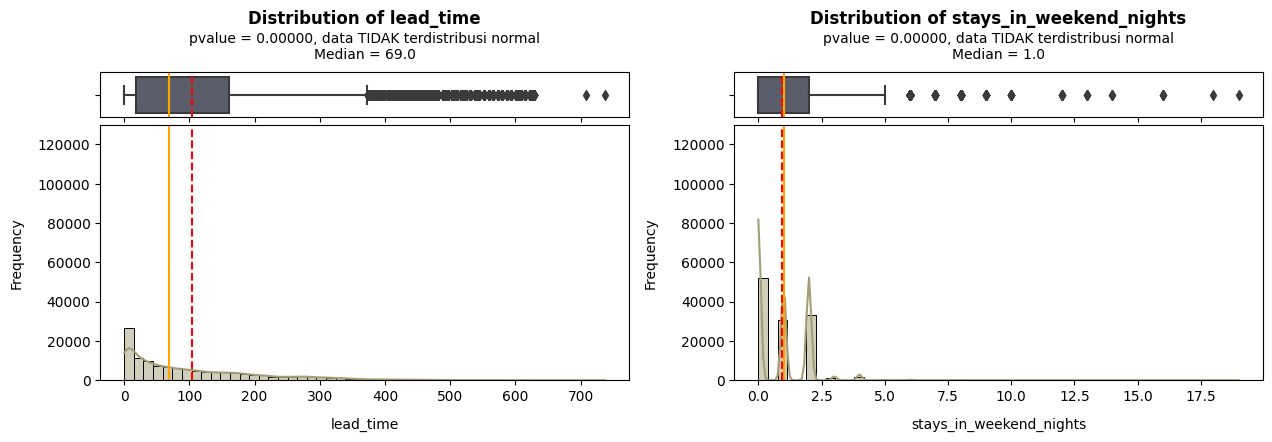

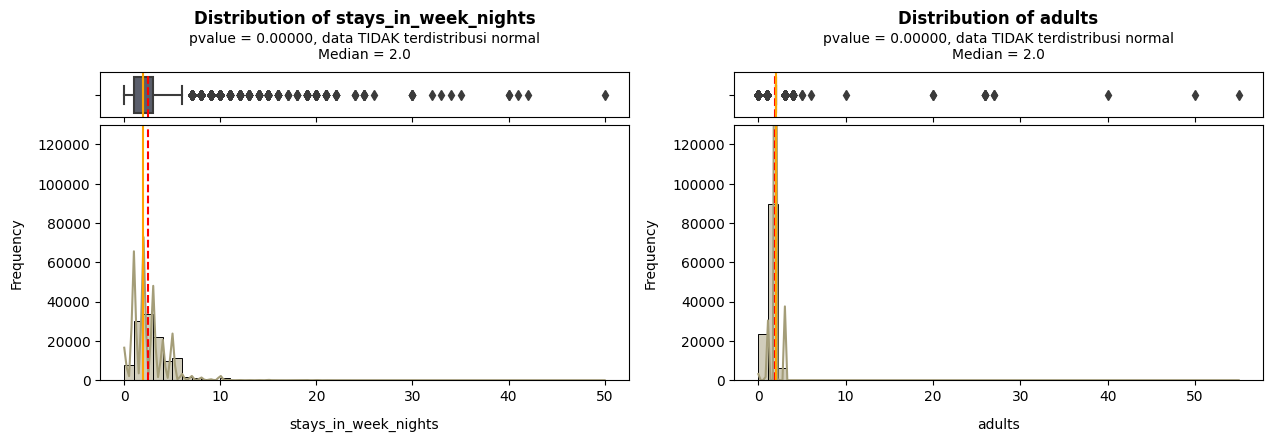

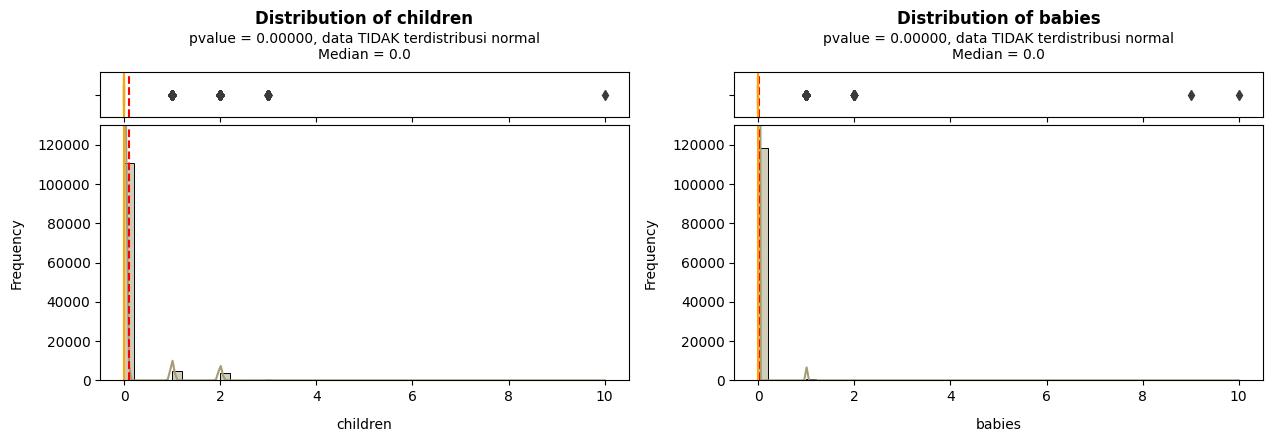

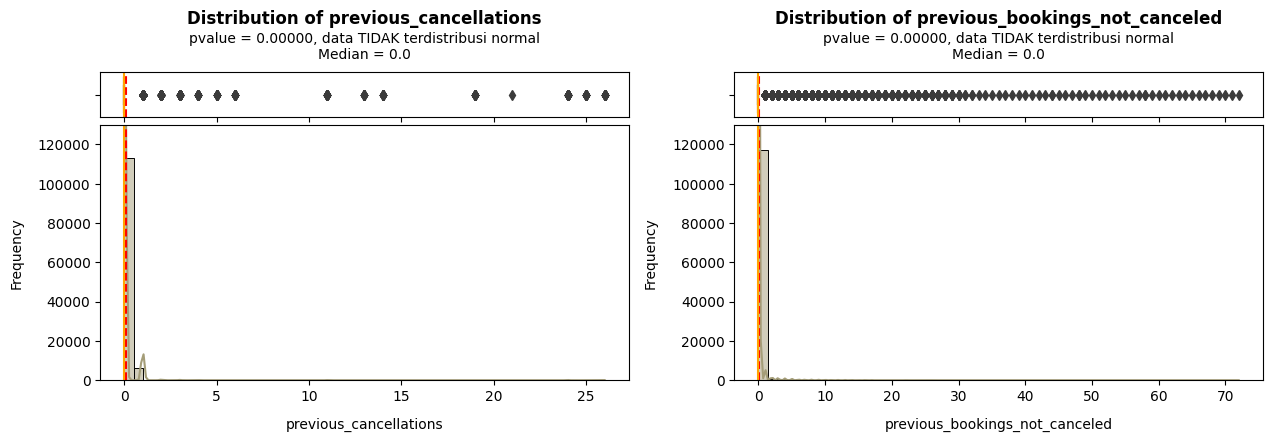

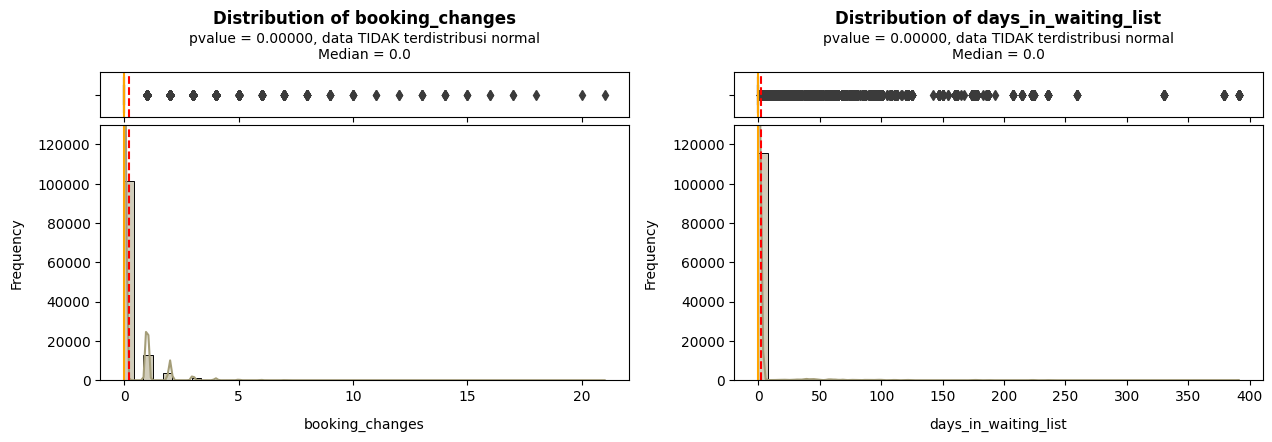

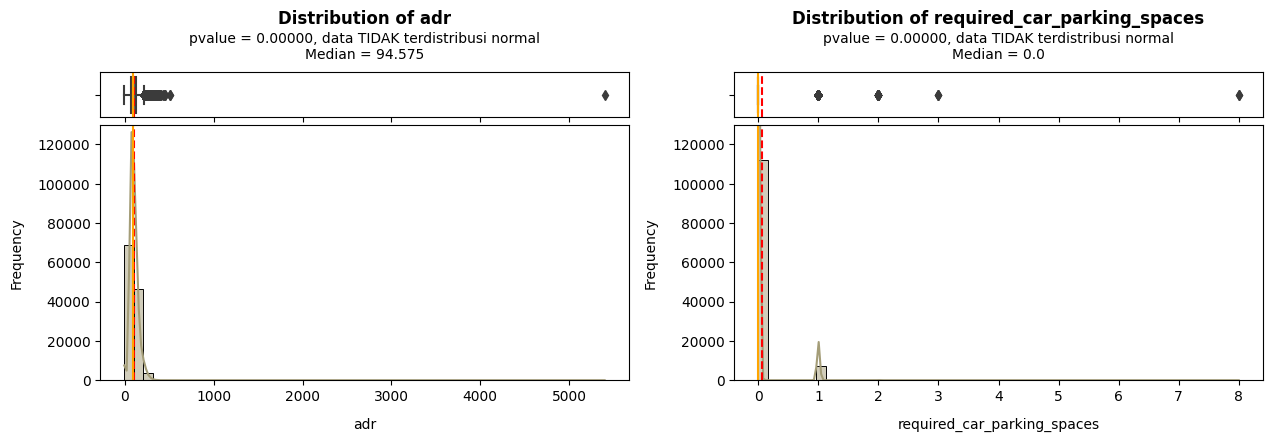

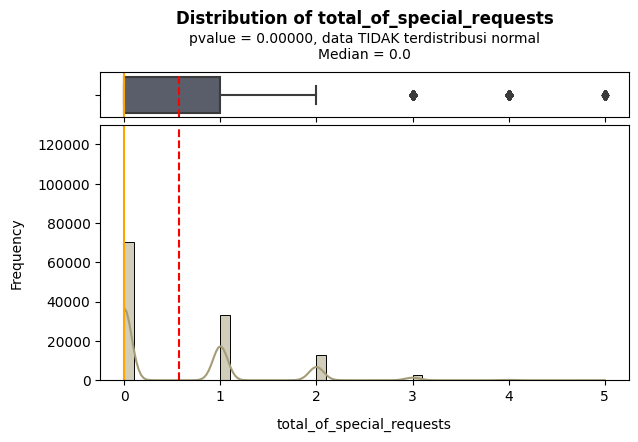

In [8]:
# menampilkan distribusi data pada feature numerikal beserta uji normalitasnya
features = [
    numerical_features[:2],
    numerical_features[2:4],
    numerical_features[4:6],
    numerical_features[6:8],
    numerical_features[8:10],
    numerical_features[10:12],
    numerical_features[12]
]

for plot in features:    
    if plot == numerical_features[12]:
        # plot untuk numerical_features index ke-12
        fig, ax = plt.subplots(
            nrows = 2,
            ncols = 1,
            figsize = (6.82, 4),
            gridspec_kw = {
                "height_ratios" : (.15, .85),
                "hspace" : 0.05
            }
        )
        ax = ax.flatten()
        stat, pvalue = normaltest(df[plot].dropna())
        if pvalue > 0.05:
            distribution = f"pvalue = {pvalue:.5f}, data terdistribusi normal\nMedian = {df[plot].median()}"
        else:
            distribution = f"pvalue = {pvalue:.5f}, data TIDAK terdistribusi normal\nMedian = {df[plot].median()}"

        # menampilkan boxplot & title
        sns.boxplot(x = df[plot], ax = ax[0], color = "#575C6E", medianprops = dict(color = "orange"))
        ax[0].axvline(df[plot].mean(), color = "red", linestyle = "--")
        ax[0].axvline(df[plot].median(), color = "orange", linestyle = "-")
        ax[0].set_title(f"Distribution of {plot}\n", fontsize = 12, pad = 20, fontweight = "bold")
        ax[0].text(x = 0.5, y = 1.3, s = distribution, ha = "center", transform = ax[0].transAxes)

        # menampilkan histplot
        sns.histplot(data = df[plot], ax = ax[1], kde = True, stat = "count", bins = 50, color = "#A49D78")
        ax[1].axvline(df[plot].mean(), color = "red", linestyle = "--")
        ax[1].axvline(df[plot].median(), color = "orange", linestyle = "-")
        ax[1].set_xlabel(plot, labelpad = 10)
        ax[1].set_ylabel("Frequency", labelpad = 10)
        ax[1].set_ylim(0, 130000)
    else:
        # plot untuk numerical_features index ke-0 hingga ke-11
        fig, ax = plt.subplots(
            nrows = 2,
            ncols = 2,
            figsize = (15, 4),
            gridspec_kw = {
                "height_ratios" : (.15, .85),
                "hspace" : 0.05
            }
        )
        ax = ax.flatten()
        for i, num_cols in enumerate(plot):
            stat, pvalue = normaltest(df[num_cols].dropna())
            if pvalue > 0.05:
                distribution = f"pvalue = {pvalue:.5f}, data terdistribusi normal\nMedian = {df[num_cols].median()}"
            else:
                distribution = f"pvalue = {pvalue:.5f}, data TIDAK terdistribusi normal\nMedian = {df[num_cols].median()}"

            # menampilkan boxplot & title
            sns.boxplot(x = df[num_cols], ax = ax[i], color = "#575C6E", medianprops = dict(color = "orange"))
            ax[i].axvline(df[num_cols].mean(), color = "red", linestyle = "--")
            ax[i].axvline(df[num_cols].median(), color = "orange", linestyle = "-")
            ax[i].set_title(f"Distribution of {num_cols}\n", fontsize = 12, pad = 20, fontweight = "bold")
            ax[i].text(x = 0.5, y = 1.3, s = distribution, ha = "center", transform = ax[i].transAxes)

            # menampilkan histplot
            sns.histplot(data = df[num_cols], ax = ax[i+2], kde = True, stat = "count", bins = 50, color = "#A49D78")
            ax[i+2].axvline(df[num_cols].mean(), color = "red", linestyle = "--")
            ax[i+2].axvline(df[num_cols].median(), color = "orange", linestyle = "-")
            ax[i+2].set_xlabel(num_cols, labelpad = 10)
            ax[i+2].set_ylabel("Frequency", labelpad = 10)
            ax[i+2].set_ylim(0, 130000)
    plt.tight_layout()
    plt.show()

Berdasarkan *output* di atas, semua *feature* numerikal memiliki data yang **TIDAK** terdistribusi normal. Hal tersebut didukung dengan visualisasi *histogram* dari semua *feature*-nya yang terlihat ***right-skewed*** atau ***positive skew***, serta telah dibuktikan juga dengan uji normalitas menggunakan D’Agostino and Pearson, di mana semua nilai **pvalue**-nya berada di bawah 0,05. Selain itu, kita dapat mengetahui bahwa semua *feature* numerikal memiliki banyak *outlier*, yang mana hal tersebut akan kita *breakdown* lebih lanjut saat tahap *preprocessing*. Adapun *insight* lainnya terkait semua *feature* di atas yang akan dijabarkan pada tabel di bawah ini.

| Attribute | Insight |
| --- | --- |
| `lead_time` | Mayoritas periode waktu seorang pelanggan untuk menunggu dari tanggal melakukan *booking* hingga tanggal *check-in* berada pada rentang 0 hingga 150 hari. |
| `stays_in_weekend_nights` | Sebagian besar pelanggan yang berencana atau telah melakukan *check-in* saat *weekend* biasanya menginap antara 0 hingga 2 malam. |
| `stays_in_week_nights` | Sebagian besar pelanggan yang berencana atau telah melakukan *check-in* selama hari kerja biasanya menginap antara 0 hingga 5 malam. |
| `adults` | Umumnya, jumlah orang dewasa yang akan atau pernah melakukan *check-in* berada pada rentang 0 hingga 2 orang.  |
| `children` | Sebagian besar *booking* hotel dipesan dengan tidak membawa atau bahkan tidak berniat membawa anak-anak.  |
| `babies` | Hampir semua pemesan yang melakukan *booking* hotel tidak membawa atau bahkan tidak berniat membawa bayi. |
| `previous_cancellations` | Mayoritas pemesan tidak melakukan pembatalan *booking* hotel pada pemesanan sebelumnya. Di sisi lain, bisa saja mayoritas pemesan merupakan pelanggan baru atau bukan *repeated guest* jika kita merujuk pada [deskripsi](https://www.sciencedirect.com/science/article/pii/S2352340918315191#bib5) kolom tersebut. |
| `previous_bookings_not_canceled` | Sebagian besar pelanggan yang melakukan pemesanan hotel sebelumnya tidak membatalkan reservasi mereka. Di sisi lain, bisa saja mayoritas pemesan merupakan pelanggan baru atau bukan *repeated guest* jika kita merujuk pada [deskripsi](https://www.sciencedirect.com/science/article/pii/S2352340918315191#bib5) kolom tersebut. |
| `booking_changes` | Mayoritas pemesan tidak melakukan penggantian data *booking* hotel. |
| `days_in_waiting_list` | Pemesanan pada hotel ini jarang terjadi *waiting list*. |
| `adr` | Median *Average Daily Rate* untuk pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017 berada di angka 94,575 EUR. |
| `required_car_parking_spaces` | Hampir semua pemesan tidak memerlukan lahan untuk parkir mobil. |
| `total_of_special_requests` | Mayoritas pelanggan meminta 0 hingga 1 *special request* saat melakukan pemesanan hotel. |

### `Data Correlation (Numerical Features)`

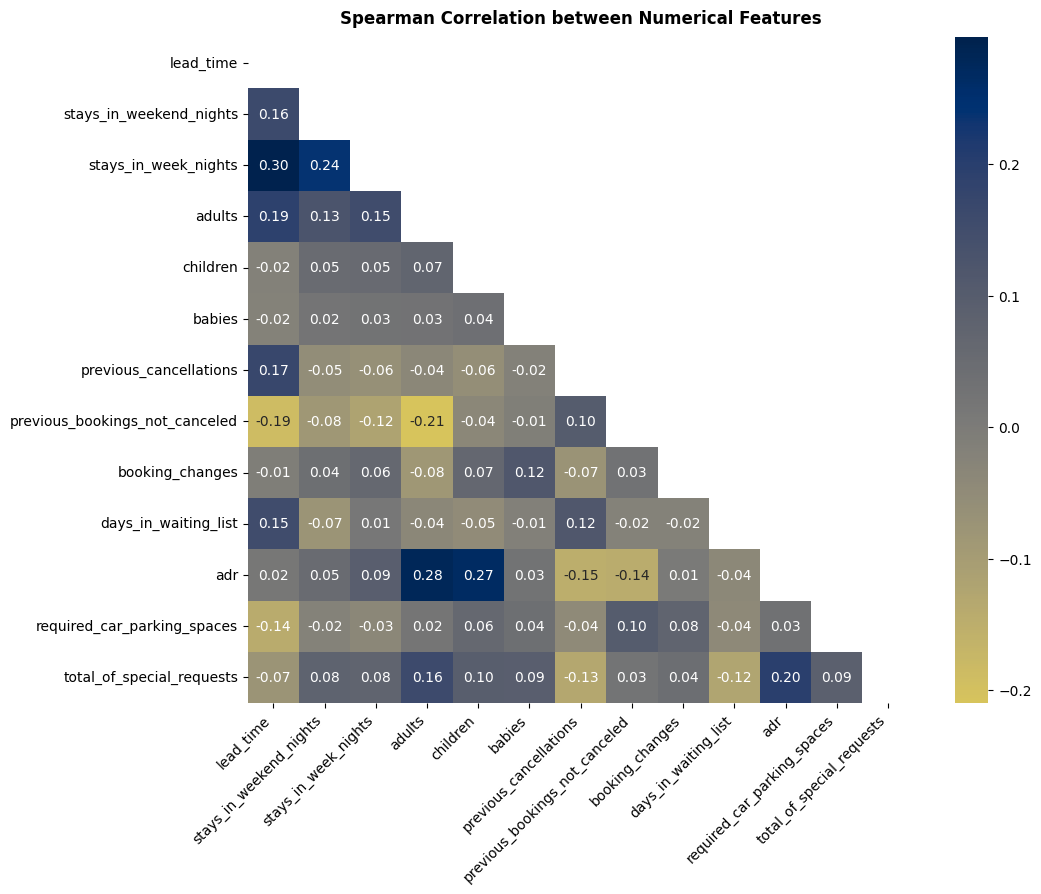

In [9]:
# menghitung korelasi setiap feature numerikal
num_correlation = df[numerical_features].corr(method = "spearman")
matrix = np.triu(num_correlation)
plt.figure(figsize = (11, 11))
ax = sns.heatmap(
    data = num_correlation,
    annot = True,
    fmt = ".2f",
    cmap = "cividis_r",   
    center = 0,
    mask = matrix,
    square = True,
    cbar_kws = {"shrink" : 0.685}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = "right"
)
plt.title("Spearman Correlation between Numerical Features", fontsize = 12, pad = 10, fontweight = "bold")
plt.tight_layout()
plt.show()

Berdasarkan *correlation matrix* di atas, kita dapat melihat bahwa nilai korelasi positif tertinggi terdapat pada hubungan antara kolom `lead_time` dan `stays_in_week_nights`, sedangkan untuk nilai korelasi negatif tertinggi terdapat pada hubungan antara kolom `adults` dan `previous_bookings_not_canceled`. Kita tidak akan berbicara lebih lanjut lagi terkait *correlation matrix* yang disajikan di atas, karena jika kita periksa hubungan antar *feature* numerikal satu dan yang lainnya, terlihat bahwa korelasinya relatif rendah (nilainya berada pada rentang -0,3 hingga 0 hingga 0,3). Hal tersebut mungkin disebabkan oleh variasi yang kompleks dan *non-linear* antar *feature* tersebut, serta sifat unik dari setiap *feature* numerikal yang tidak secara langsung berkorelasi satu sama lain.

### `Data Cardinality (Categorical Features)`

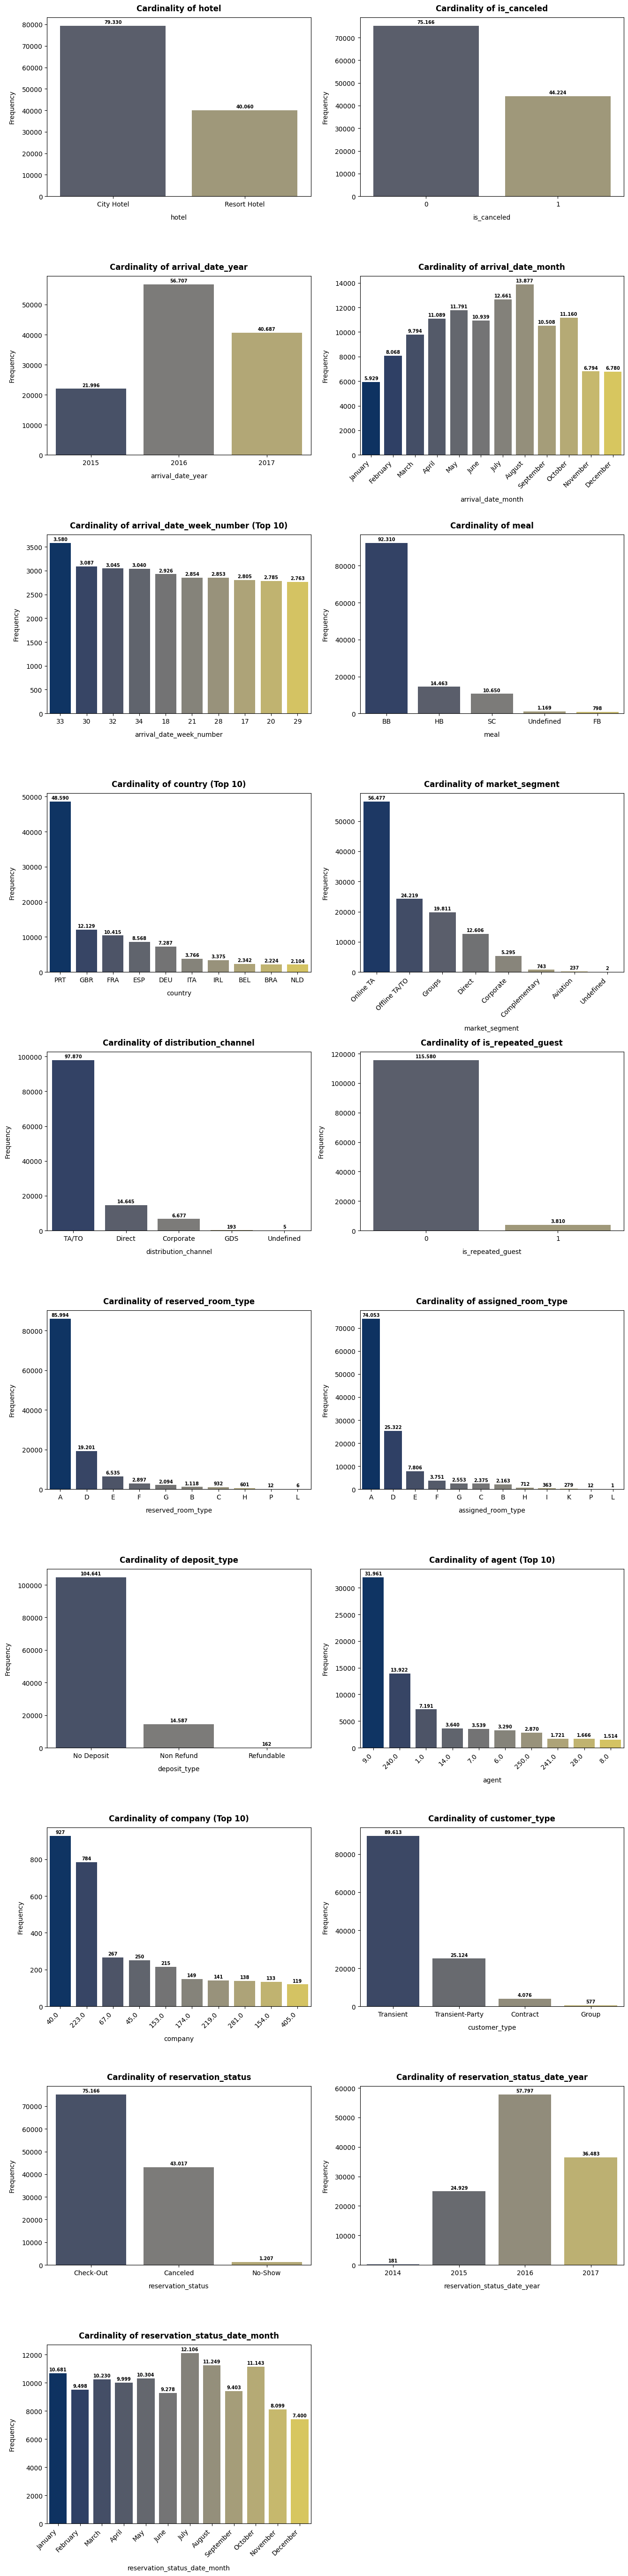

In [10]:
# membuat countplot untuk setiap feature kategorikal
top_ten = [
    "arrival_date_week_number",
    "country",
    "agent",
    "company"
]

unordered_features = [
    "arrival_date_year",
    "arrival_date_month",
    "reservation_status_date_year",
    "reservation_status_date_month"
]

ordered_month = [
    "arrival_date_month",
    "reservation_status_date_month"
]

rotate_labels = [
    "arrival_date_month",
    "market_segment",
    "agent",
    "company",
    "reservation_status_date_month"
]

number_plots = min(len(categorical_features), 20)
fig, ax = plt.subplots(10, 2, figsize = (13.5, 55))
plot_counter = 0
for i in range(10):
    for j in range(2):
        if plot_counter >= number_plots:
            fig.delaxes(ax[i, j])
        else:
            feature = categorical_features[plot_counter]
            if feature in top_ten:
                order = df[feature].value_counts().index[:10]
                title = f"Cardinality of {feature} (Top 10)"
            else:
                if feature in unordered_features:
                    if feature in ordered_month:
                        order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
                    else:    
                        order = None
                else:
                    order = df[feature].value_counts().index
                title = f"Cardinality of {feature}"
            sns.countplot(data = df, x = feature, ax = ax[i, j], order = order, palette = "cividis")
            ax[i, j].set_title(title, fontsize = 12, pad = 10, fontweight = "bold")
            if feature in rotate_labels:
                ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation = 45, horizontalalignment = "right")
                ax[i, j].set_xlabel(feature, labelpad = 10)
            else:
                ax[i, j].set_xlabel(feature, labelpad = 10)
            ax[i, j].set_ylabel("Frequency", labelpad = 10)
            for container in ax[i, j].containers:
                ax[i, j].bar_label(
                    container,
                    labels = [f"{x:,.0f}".replace(",", ".") for x in container.datavalues],
                    label_type = "edge",
                    padding = 2,
                    color = "black",
                    fontweight = "bold",
                    fontsize = 7
                )
        plot_counter += 1
plt.tight_layout()
plt.show()


| Attribute | Insight |
| --- | --- |
| `hotel` | Terlihat pada *dataset* bahwa mayoritas pemesan hotel melakukan pemesanan untuk *City Hotel* (informasi ini dapat diketahui juga saat menampilkan *output* *descriptive statistics* di atas). Hal tersebut sangatlah masuk akal, mengingat lokasi dan aksesibilitas untuk *City Hotel* mudah diakses oleh transportasi umum lantaran lokasinya yang berada di daerah Ibu Kota. |
| `is_canceled` | Mayoritas dari jumlah transaksi yang terjadi di hotel ini berhasil, dengan kata lain bahwa sebagian besar transaksi tidak mengalami pembatalan. Hal tersebut bisa disebabkan oleh fakta bahwa sebagian besar pelanggan telah merencanakan reservasi mereka dengan cukup baik dan matang, sehingga cenderung tidak membatalkan reservasinya. Bukti dari pernyataan tersebut dapat didukung oleh kolom `booking_changes` yang menunjukkan bahwa minimnya perubahan yang terjadi pada data pemesanan hotel. |
| `arrival_date_year` | Terjadinya fluktuasi jumlah pemesanan dari tahun 2015 hingga 2017 yang cenderung meningkat dengan puncak konsumennya yang terjadi pada tahun 2016. Alasan mengapa pada tahun 2016 mencatatkan jumlah pemesanan tertinggi yaitu bisa jadi karena meningkatnya popularitas tujuan wisata di Portugal pada periode tersebut, khususnya untuk kota Lisbon dan Algarve. Selain itu, alasan paling masuk akalnya adalah karena *dataset* ini mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, sehingga secara otomatis data pemesanan yang berada di tahun 2016 memiliki kuantitas yang lebih besar dibandingkan data pemesanan di tahun 2015 dan 2017. |
| `arrival_date_month` | Bulan Agustus merupakan bulan yang paling banyak diminati oleh para pelanggan. Hal ini mungkin disebabkan oleh popularitasnya yang tinggi sebagai bulan liburan [musim panas di Portugal](https://www.bookmundi.com/ng/summer-in-portugal-weather-beaches-and-more). Cuaca yang hangat dan cerah di bulan Agustus juga membuatnya menjadi pilihan yang menarik bagi wisatawan dalam negeri dan mancanegara untuk menikmati liburan santai di tempat-tempat wisata seperti pantai, sehingga mereka membutuhkan akomodasi untuk tempat menginap. Selain itu, alasan paling masuk akalnya adalah karena *dataset* ini mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, sehingga secara otomatis data pemesanan yang berada di bulan Agustus (dan bulan Juli) memiliki kuantitas yang lebih besar dibandingkan data pemesanan di bulan lainnya. |
| `arrival_date_week_number` | Minggu ke-33 menunjukkan tingginya jumlah pemesan yang dijadwalkan untuk *check-in*. Alasan mengapa minggu ke-33 di setiap tahunnya menjadi minggu dengan jumlah reservasi paling tinggi yaitu karena adanya libur musim panas yang umumnya terjadi pada periode tersebut. Faktanya, [minggu ke-33](https://www.calendar-week.org/calendar-weeks/2016) merupakan minggu yang berada pada bulan Agustus, sehingga wajar jika data tertinggi pada kolom ini hasilnya sesuai dengan data tertinggi yang terdapat pada kolom `arrival_date_month`. Selain itu, alasan paling masuk akalnya adalah karena *dataset* ini mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, sehingga secara otomatis data pemesanan yang berada di minggu-minggu pada bulan Agustus (dan bulan Juli) memiliki kuantitas yang lebih besar dibandingkan data pemesanan di minggu-minggu pada bulan lainnya. |
| `meal` | Paket makanan BB atau *Bed and Breakfast* lebih sering dipilih oleh pemesan saat melakukan *booking* hotel dengan asumsi agar mereka tidak perlu mencari sarapan di luar hotel setiap pagi demi menghemat waktu dan tenaga. |
| `country` | Diagram menunjukkan bahwa banyaknya pengunjung hotel berasal dari negara dengan kode PRT atau Portugal. Hal tersebut sangatlah masuk akal karena lokasi hotelnya yang berada di negara Portugal itu sendiri. |
| `market_segment` | Berdasarkan segmentasi pasar yang dibuat oleh pihak hotel, transaksi *booking* terbanyak berasal dari *Online Travel Agent* (OTA). Alasan kuatnya adalah karena OTA menawarkan kemudahan dan kenyamanan bagi pelanggan dalam mencari dan memesan akomodasi secara *online*. OTA juga sering kali menawarkan berbagai pilihan akomodasi dengan harga yang kompetitif, serta fitur perbandingan harga dan ulasan dari pengguna sebelumnya yang membantu pelanggan dalam membuat keputusan yang tepat. Selain itu, kerjasama antara hotel dan OTA dapat meningkatkan visibilitas hotel dan mencapai pangsa pasar yang lebih luas, terutama di kalangan wisatawan yang mencari fleksibilitas dan kemudahan dalam merencanakan perjalanan mereka. |
| `distribution_channel` | Mayoritas saluran distribusi untuk setiap *booking* hotel yang dipilih oleh pelanggan berasal dari *Travel Agent* (TA) atau *Tour Operators* (TO). TA/TO sering memiliki pengetahuan yang luas tentang destinasi wisata dan dapat memberikan saran serta paket liburan yang sesuai dengan kebutuhan pelanggan. Selain itu, mereka juga dapat menawarkan paket-paket yang termasuk akomodasi, transportasi, dan aktivitas wisata dengan harga yang kompetitif. Kerjasama antara hotel dan TA/TO juga dapat memberikan manfaat bagi kedua belah pihak dalam hal pemasaran dan peningkatan penjualan. |
| `is_repeated_guest` | Sekitar 96,8% pemesan berasal dari tamu yang tidak termasuk ke dalam kategori tamu berulang atau *repeated guest*. Alasannya mungkin karena pihak hotel melakukan promosi yang lebih ditujukan untuk menarik banyak tamu baru, program loyalitas, atau bisa saja memang karena popularitasnya sebagai tempat penginapan atau destinasi wisata yang menarik bagi wisatawan baru. Selain itu, beberapa tamu mungkin lebih cenderung mencari pengalaman serta variasi baru dalam akomodasi mereka daripada kembali ke tempat yang sama setiap kali mereka melakukan perjalanan. |
| `reserved_room_type` | Sebagian besar pemesan memilih tipe kamar A (sekitar 72%). Kita asumsikan bahwa tipe kamar ini mungkin menawarkan kenyamanan dan fasilitas yang cukup memadai bagi sebagian besar tamu. Selain itu, tipe kamar A mungkin memiliki harga yang lebih terjangkau atau lebih mudah tersedia dibandingkan dengan tipe kamar lainnya. |
| `assigned_room_type` | Terdapat kesenjangan dan ketidaksesuaian antara tipe kamar yang dipesan dengan tipe kamar yang ditetapkan oleh pihak hotel. Terlihat hanya sekitar 86% pemesanan yang memilih tipe kamar A mendapatkan kamar yang sesuai, dengan kata lain 14% pemesanan sisanya ditetapkan dengan tipe kamar yang berbeda. Kesenjangan tersebut dapat disebabkan oleh berbagai faktor, misalnya seperti ketersediaan kamar, kebijakan hotel, permintaan perubahan dari pelanggan, serta kemungkinan adanya kesalahan sistem atau *human error* (baik dari pelanggan atau pegawai hotel) saat proses reservasi. |
| `deposit_type` | Sebagian besar pelanggan tidak melakukan *deposit* saat memesan hotel. Hal tersebut mungkin di karenakan kebijakan hotel yang memperbolehkan reservasi tanpa *deposit* atau karena kebutuhan fleksibilitas serta kenyamanan pelanggan dalam merencanakan perjalanan. |
| `agent` | Pada diagram yang menampilkan peringkat sepuluh teratas dari *agent* yang pernah melakukan *booking* hotel, *agent* bernomor ID 9 merupakan *agent* dengan jumlah pemesanan hotel terbanyak. |
| `company` | Pada diagram yang menampilkan peringkat sepuluh teratas dari *company* yang pernah melakukan *booking* hotel, *company* bernomor ID 40 merupakan *company* dengan jumlah pemesanan hotel terbanyak. |
| `customer_type` | Tipe pelanggan yang paling umum melakukan pemesanan adalah *Transient*, yang menunjukkan bahwa 75% dari total pelanggan hanya memesan hotel untuk jangka waktu yang singkat. |
| `reservation_status` | Sekitar 62,9% pemesanan hotel tidak dibatalkan atau pemesan berhasil melakukan *check-out*. Hal tersebut telah dipaparkan juga pada *insight* kolom `is_canceled` serta tabel *skimming* di atas. |
| `reservation_status_date_year` | Sebagian besar status pemesanan hotel terjadi di tahun 2016, baik itu pemesanan yang dibatalkan ataupun yang berhasil (pelanggan melakukan *check-in* dan berhasil *check-out*). Alasan paling masuk akalnya adalah karena *dataset* ini mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, sehingga secara otomatis data pemesanan yang berada di tahun 2016 memiliki kuantitas yang lebih besar dibandingkan data pemesanan di tahun 2015 dan 2017. |
| `reservation_status_date_month` | Pihak hotel lebih banyak menerima kejelasan terkait setiap pemesanan di bulan Juli, dari mulai reservasi yang berhasil (pelanggan melakukan *check-in* dan berhasil *check-out*) hingga yang dibatalkan oleh pelanggan. Alasan di baliknya yaitu karena *dataset* ini mencakup pemesanan yang dijadwalkan tiba antara tanggal 1 Juli 2015 dan 31 Agustus 2017, sehingga secara otomatis data pemesanan yang berada di bulan Juli (dan bulan Agustus) memiliki kuantitas yang lebih besar dibandingkan data pemesanan di bulan lainnya. |

### `Identify Duplicates`

In [11]:
# menampilkan data duplikat
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 31994


Setelah dilakukan pengecekan, ternyata *dataset* ini mengandung data duplikat sebanyak 31.994 data (informasi ini dapat dilihat pada tabel *skimming* di atas). Semua data duplikat harus di hapus agar tidak terjadi bias atau ketidakakuratan yang dapat mempengaruhi hasil analisis dan interpretasi data, sehingga kita perlu melakukan penanganan terhadap data duplikat tersebut pada tahap *preprocessing*.

### `Identify Missing Value`

children    4     
country     488   
agent       16340 
company     112593
dtype: int64


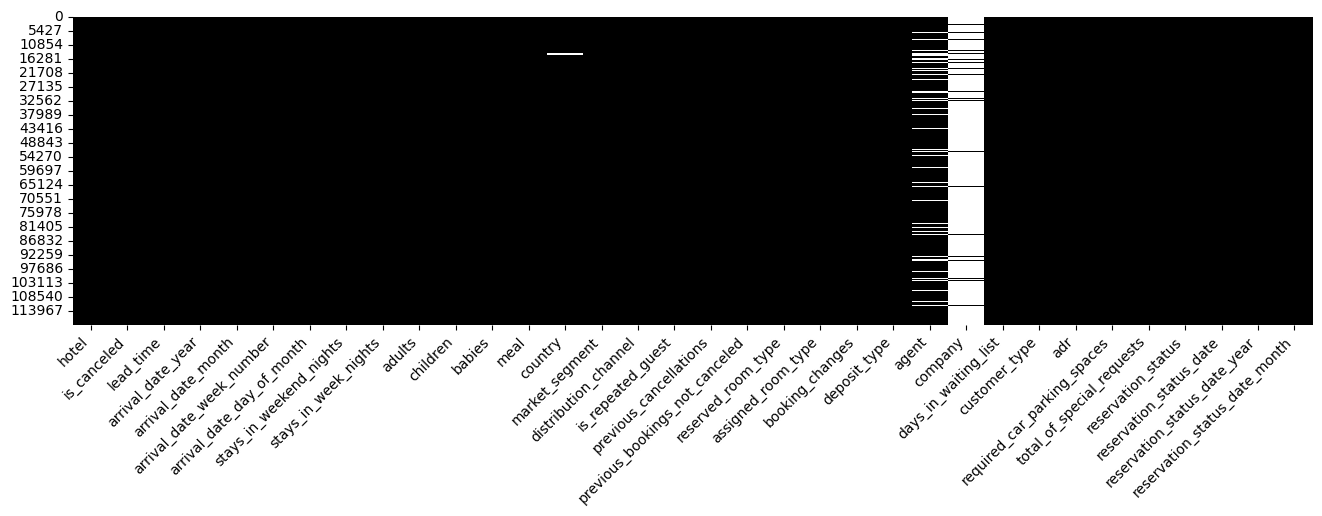

In [12]:
# menampilkan missing value
print(df.isna().sum()[df.isna().sum() > 0])
plt.figure(figsize = (16, 4))
ax = sns.heatmap(data = df.isna(), cmap = "bone", cbar = False)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = "right"
)
plt.show()

Secara garis besar, *dataset* ini memiliki *missing value* pada kolom `children` (0,003%), `country` (0,4%), `agent` (13,6%), dan `company` (94,3%), sehingga kita perlu melakukan penanganan terhadap *missing value*-nya pada tahap *preprocessing* (informasi ini dapat dilihat pada tabel *skimming* di atas). Hal tersebut dapat terlihat sangat jelas ketika menampilkan *output* pertama yang menunjukkan masing-masing jumlah dari *missing value*-nya, serta pada *output* kedua yang memperlihatkan garis putih penanda adanya *missing value*, walaupun pada kolom `children` tidak terlihat adanya garis putih tersebut (asumsi: di karenakan jumlah *missing value* nya yang hanya 4 baris).

## **PREPROCESSING**

### `Remove Data Duplication`

In [13]:
# menghapus data duplikat
df = df.drop_duplicates()
if df.duplicated().sum() == 0:
    print(colored(f"Data duplikat berhasil dihapus!\n", "green"))
    #print(f"Data duplikat berhasil dihapus.\n")
    print(f"Jumlah keseluruhan data sebelumnya: {len(df_source)}")
    print(f"Jumlah keseluruhan data sekarang: {len(df)}")
else:
    print(colored(f"Data duplikat BELUM berhasil dihapus!", "red"))

Data duplikat berhasil dihapus!

Jumlah keseluruhan data sebelumnya: 119390
Jumlah keseluruhan data sekarang: 87396


### `Fill Missing Value & Casting Data Type`

Sebelum melakukan penanganan terhadap *missing value*, mari kita lihat terlebih dahulu apakah ada korelasi nulitas antar *feature* yang memiliki *missing value*.

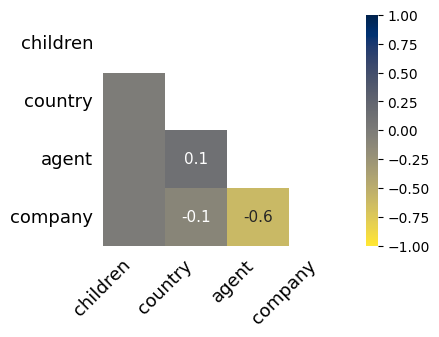

In [14]:
# menampilkan korelasi nulitas antar feature yang memiliki missing value
msno.heatmap(df = df, cmap = "cividis_r", figsize = (4, 3), fontsize = 13)
plt.show()

*Output* di atas merupakan *heatmap* yang menunjukkan korelasi nulitas antar *feature* yang memiliki *missing value*. Korelasi nulitas berkisar dari -1 (jika suatu variabel muncul, maka variabel lainnya pasti tidak muncul) hingga 0 (variabel yang muncul atau tidak muncul sama sekali tidak berpengaruh satu sama lain) hingga 1 (jika suatu variabel muncul, maka variabel lainnya pasti muncul).

Terlihat bahwa rata-rata *missing values* antar *feature* itu hampir tidak berkorelasi atau tidak berpengaruh satu sama lain, dan jika ada pun nilainya hanya 0,1 dan -0,1 yang berarti korelasi nulitasnya sangat rendah. Berbeda halnya dengan kolom `company` dan `agent` yang memiliki korelasi nulitasnya *moderate* dengan nilai -0,6 yang mengartikan jika baris pada kolom `company` berisi data, maka rata-rata baris pada kolom `agent` tidak berisi data atau NaN, dan begitu pula sebaliknya. Hal tersebut dapat didukung oleh *heatmap* yang ditampilkan saat melakukan pengecekan terhadap *missing value* di atas, di mana ketika warna baris pada kolom `company` bergaris hitam, maka warna baris pada kolom `agent` berwarna putih.

Kedua kolom tersebut perlu di-*breakdown* lebih lanjut sebelum dilakukan penanganan terhadap keduanya, dan jika terbukti bahwa kolom `company` dan `agent` saling melengkapi, maka kita akan menyatukan keduanya agar dapat mempermudah proses analisis.

**Penanganan *missing value* pada kolom `children` serta mengubah tipe datanya**

In [15]:
# menampilkan data yang memiliki missing value pada kolom children
display(df[df["children"].isna()])
print(f"Jumlah missing value setelah menghapus data duplikat: {len(df[df['children'].isna()])}")

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
40600,City Hotel,1,2,2015,August,32,3,1,0,2,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NaN,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01,2015,August
40667,City Hotel,1,1,2015,August,32,5,0,2,2,NaN,0,BB,PRT,Direct,Undefined,0,0,0,B,B,0,No Deposit,14.0,NaN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04,2015,August
40679,City Hotel,1,1,2015,August,32,5,0,2,3,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NaN,NaN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04,2015,August
41160,City Hotel,1,8,2015,August,33,13,2,5,2,NaN,0,BB,PRT,Online TA,Undefined,0,0,0,B,B,0,No Deposit,9.0,NaN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09,2015,August


Jumlah missing value setelah menghapus data duplikat: 4


Untuk penanganan *missing value* pada kolom `children`, kita asumsikan bahwa **pemesan tidak mengisi informasi terkait jumlah anak-anak yang akan ikut *check in* karena memang tidak ada anak-anak yang akan dibawa oleh pemesan**, dengan kata lain data *booking* hotel di atas seharusnya memiliki nilai 0 pada kolom `children`. Maka dari itu, kita akan *assign* nilai **0** pada keempat *missing value* tersebut. Setelah melakukan pengisian *missing value*, kita akan mengubah tipe data pada kolom `children`, mengingat ketika kita mempelajari *dataset* di atas, kolom tersebut masih bertipe data *float* (seharusnya bertipe data *integer*), sehingga kita perlu mengubahnya pada proses ini.

In [16]:
# mengisi nilai 0 pada kolom children yang bernilai NaN
df["children"] = df["children"].fillna(0)

# mengubah tipe data children menjadi integer
df["children"] = df["children"].astype(int)

**Penanganan *missing value* pada kolom `country`**

In [17]:
# menampilkan data yang memiliki missing value pada kolom country
display(df[df["country"].isna()])
print(f"Jumlah missing value setelah menghapus data duplikat: {len(df[df['country'].isna()])}")

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
30,Resort Hotel,0,118,2015,July,27,1,4,10,1,0,0,BB,NaN,Direct,Direct,0,0,0,A,A,2,No Deposit,NaN,NaN,0,Transient,62.0,0,2,Check-Out,2015-07-15,2015,July
4127,Resort Hotel,1,0,2016,February,8,15,0,0,0,0,0,SC,NaN,Offline TA/TO,TA/TO,0,0,0,P,P,0,No Deposit,NaN,383.0,0,Transient,0.0,0,0,Canceled,2016-02-15,2016,February
7092,Resort Hotel,1,8,2016,July,30,21,0,1,1,0,0,BB,NaN,Corporate,Corporate,0,0,0,A,A,0,No Deposit,NaN,204.0,0,Transient,73.0,0,2,Canceled,2016-07-20,2016,July
7860,Resort Hotel,1,39,2016,August,36,30,0,5,2,0,0,HB,NaN,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,159.0,0,5,Canceled,2016-07-22,2016,July
8779,Resort Hotel,1,0,2016,October,42,13,0,1,1,0,0,BB,NaN,Corporate,Corporate,0,0,0,A,A,0,No Deposit,NaN,457.0,0,Transient,50.0,0,0,Canceled,2016-10-13,2016,October
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60651,City Hotel,1,0,2016,November,47,17,4,11,0,0,0,SC,NaN,Corporate,Direct,0,0,0,P,P,0,No Deposit,NaN,279.0,0,Transient,0.0,0,0,Canceled,2016-11-17,2016,November
61244,City Hotel,1,0,2016,December,50,6,0,0,0,0,0,SC,NaN,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NaN,279.0,0,Transient,0.0,0,0,Canceled,2016-12-06,2016,December
65907,City Hotel,1,0,2017,April,15,10,0,0,0,0,0,SC,NaN,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NaN,279.0,0,Transient,0.0,0,0,Canceled,2017-04-10,2017,April
80830,City Hotel,0,4,2015,November,48,23,1,2,1,0,0,BB,NaN,Groups,TA/TO,0,0,0,A,A,0,No Deposit,37.0,NaN,0,Transient-Party,70.0,0,0,Check-Out,2015-11-26,2015,November


Jumlah missing value setelah menghapus data duplikat: 452


Sama halnya dengan kolom `children`, penanganan *missing value* pada kolom `country` juga kita asumsikan bahwa **pemesan tidak ingin menginputkan informasi terkait asal negara mereka karena alasan privasi & keamanan, kelalaian saat menginputkan data diri, atau mungkin beberapa *platform* pemesanan hotel tidak meminta informasi terkait negara (data opsional)**. Dengan kata lain, data *booking* hotel di atas seharusnya memiliki data terkait negara di setiap pemesannya. Permasalahannya, kita tidak tahu dari negara mana pemesan itu berasal, sehingga kita memutuskan untuk men-*assign* nilai ***UNKNOWN*** pada seluruh *missing value* tersebut.

In [18]:
# mengisi nilai UNKNOWN pada kolom country yang bernilai NaN
df["country"] = df["country"].fillna("UNKNOWN")

**Penanganan *missing value* pada kolom `agent` dan `company` serta mengubah kedua tipe datanya**

In [19]:
# menampilkan data yang memiliki missing value pada kolom agent
display(df[df["agent"].isna()])
print(f"Jumlah missing value setelah menghapus data duplikat: {len(df[df['agent'].isna()])}\n")

# menampilkan data yang memiliki missing value pada kolom company
display(df[df["company"].isna()])
print(f"Jumlah missing value setelah menghapus data duplikat: {len(df[df['company'].isna()])}")

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015,July
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015,July
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015,July
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.00,0,0,Check-Out,2015-07-03,2015,July
18,Resort Hotel,0,0,2015,July,27,1,0,1,2,0,0,BB,FRA,Corporate,Corporate,0,0,0,A,G,0,No Deposit,NaN,110.0,0,Transient,107.42,0,0,Check-Out,2015-07-02,2015,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119124,City Hotel,0,0,2017,August,35,29,0,1,1,0,0,BB,PRT,Complementary,Corporate,0,0,0,A,A,0,No Deposit,NaN,72.0,0,Transient,0.00,0,2,Check-Out,2017-08-30,2017,August
119151,City Hotel,0,0,2017,August,35,29,0,1,2,2,0,BB,NLD,Direct,Direct,0,0,0,G,G,0,No Deposit,NaN,NaN,0,Transient,270.00,0,0,Check-Out,2017-08-30,2017,August
119166,City Hotel,0,0,2017,August,35,30,0,1,1,0,0,BB,BRA,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,140.00,0,0,Check-Out,2017-08-31,2017,August
119215,City Hotel,0,2,2017,August,35,31,0,1,1,0,0,SC,LBN,Direct,Direct,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,140.00,0,2,Check-Out,2017-09-01,2017,September


Jumlah missing value setelah menghapus data duplikat: 12193



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015,July
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015,July
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015,July
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015,July
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017,September
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017,September
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017,September
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017,September


Jumlah missing value setelah menghapus data duplikat: 82137


Seperti yang telah kita ketahui saat melihat korelasi antar *missing values* di atas, kedua kolom tersebut memiliki korelasi nulitas *moderate* dengan nilai -0,6 yang mengartikan bahwa ketika kolom `company` terdapat data, maka kolom `agent` tidak terdapat data, begitupun juga sebaliknya. Namun setelah kita selidiki, ternyata ada 2 kondisi baru di mana **ketika kolom `company` terdapat data, maka kolom `agent` pun terdapat data** dan **ketika kolom `company` tidak terdapat data, maka kolom `agent` pun tidak terdapat data** . Hal tersebut membuat kedua kolom ini memiliki total 4 kondisi yang akan kita asumsikan sebagai berikut:

- Ketika kolom `company` terdapat data, maka kolom `agent` tidak terdapat data (asumsi: perusahaan X atau orang yang mewakilkan perusahaan X memesan hotel tidak melalui *travel agent*).
- Ketika kolom `agent` terdapat data, maka kolom `company` tidak terdapat data (asumsi: seseorang memesan hotel melalui *travel agent*).
- Ketika kolom `company` terdapat data, maka kolom `agent` pun terdapat data (asumsi: perusahaan Y atau orang yang mewakilkan perusahaan Y memesan hotel melalui *travel agent*).
- Ketika kolom `company` tidak terdapat data, maka kolom `agent` pun tidak terdapat data (asumsi: seseorang memesan hotel tidak melalui *travel agent*).

Dari keempat kondisi yang ada, kita memutuskan untuk men-*assign* nilai ***UNKNOWN*** pada seluruh *missing value* di kedua kolom `agent` dan `company`. Selain itu, kita akan menambahkan alfabet **AG** untuk data yang memiliki ID pada kolom `agent` dan alfabet **CO** untuk data yang memiliki ID pada kolom `company`.

Sebelum itu, kita perlu mengubah tipe data kedua *feature* tersebut menjadi *integer* (untuk menghilangkan koma, karena sebelumnya bertipe data *float*). Masalahnya untuk mengubah tipe data menjadi *integer*, kita perlu mengisi terlebih dahulu *missing value* yang ada, sehingga kita putuskan men-*assign* nilai **0** untuk sementara. Setelah proses tersebut, barulah kita ubah lagi tipe datanya menjadi *string* dan mengganti nilai **0** menjadi ***UNKNOWN***.

In [20]:
# proses mengubah tipe data agent dan company menjadi integer, dan mengubahnya lagi menjadi string

# agent
df["agent"] = df["agent"].fillna(0)
df["agent"] = df["agent"].astype(int)
df["agent"] = df["agent"].astype(str)

# company
df["company"] = df["company"].fillna(0)
df["company"] = df["company"].astype(int)
df["company"] = df["company"].astype(str)

# mengisi nilai UNKNOWN pada kolom agent dan company yang bernilai NaN
df = df.replace({"agent" : {"0" : "UNKNOWN"}, "company" : {"0" : "UNKNOWN"}})

In [21]:
# menambahkan alfabet AG untuk kolom agent dan CO untuk kolom company
def new_agent_id(id):
    if id == "UNKNOWN":
        return id    
    else:
        return "AG-" + id

def new_company_id(id):
    if id == "UNKNOWN":
        return id
    else:
        return "CO-" + id

df["agent"] = df["agent"].apply(new_agent_id)
df["company"] = df["company"].apply(new_company_id)

**Mengubah tipe data kolom `reservation_status_date`**

Untuk keperluan analisis, kita akan mengubah tipe data pada kolom `reservation_status_date`, meskipun akhirnya kolom ini tidak akan digunakan saat *modeling* karena datanya yang muncul setelah pemesanan hotel dibatalkan ataupun tidak dibatalkan.

In [22]:
# mengubah tipe data kolom reservation_status_date menjadi datetime
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])

### `Replace Inconsistent Variable`

**Mengganti variabel pada kolom `meal`**

Nama kategori pada kolom ini hanya ditulis dengan singkatan, yang mana dapat membingungkan *audience* ketika mendengarkan kita saat memaparkan hasil analisis. Maka dari itu, kita putuskan untuk mengganti semua nama kategorinya dengan menyesuaikan nama-nama yang ada pada laman [ini](https://www.arbat-house.com/en/articles/types-of-food-in-hotels/), sekaligus juga mengganti kategori ***Undefined*** menjadi **SC** di karenakan kedua kategori tersebut memiliki makna yang sama, yaitu 'tidak memesan makanan'.

In [23]:
# mengganti Undefined menjadi SC
df["meal"] = df["meal"].replace("Undefined", "SC")

# mengganti semua nama kategori
df = df.replace({"meal" : {"BB" : "Bed and Breakfast", "HB" : "Half Board", "FB" : "Full Board", "SC" : "Self Catering"}})

**Mengganti variabel pada kolom `market_segment`**

Terdapat nama kategori yang juga ditulis dengan singkatan pada kolom ini, yaitu ***Online TA*** dan ***Offline TA/TO***. Kedua kategori tersebut akan kita ubah menjadi ***Online Travel Agent*** untuk kategori ***Online TA***, serta ***Offline Travel Agent/Tour Operators*** untuk kategori ***Offline TA/TO***.

In [24]:
# mengganti nama kategori Online TA dan Offline TA/TO
df = df.replace({"market_segment" : {"Online TA" : "Online Travel Agent", "Offline TA/TO" : "Offline Travel Agent/Tour Operators"}})

Selain itu, kita akan mencoba untuk mengubah nilai ***Undefined*** menjadi nilai yang disesuaikan dengan identitas atau saluran distribusi dari pemesan hotel pada data tersebut.

In [25]:
# menampilkan nilai Undefined pada kolom market_segment
df[df["market_segment"] == "Undefined"]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
40600,City Hotel,1,2,2015,August,32,3,1,0,2,0,0,Bed and Breakfast,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient-Party,12.0,0,1,Canceled,2015-08-01,2015,August
40679,City Hotel,1,1,2015,August,32,5,0,2,3,0,0,Bed and Breakfast,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient-Party,18.0,0,2,Canceled,2015-08-04,2015,August


Di karenakan tidak ada identitas pemesan atau saluran distribusi yang terkait dengan reservasi di atas, maka kita putuskan untuk menghapus kedua data tersebut.

In [26]:
# menghapus data dengan nilai Undefined pada kolom market_segment
drop_data_market_segment = df[df["market_segment"] == "Undefined"].index
df = df.drop(drop_data_market_segment)

**Mengganti variabel pada kolom `distribution_channel`**

Sama halnya dengan kolom `market_segment`, kategori **TA/TO** pada kolom ini pun juga ditulis dengan singkatan dan terdapat kategori lain yang sama-sama ditulis menggunakan singkatan juga, yaitu **GDS** (*Global Distribution System*). Untuk kasus kategori **GDS**, kita akan ubah menjadi **TA/TO** karena **GDS** adalah [*platform* teknologi](https://colorwhistle.com/gds-travel-agency-guide/#:~:text=Many%20travel%20agents%20around%20the,growth%20of%20the%20travel%20industry.) yang biasanya digunakan oleh *Travel Agent/Tour Operators* untuk mengakses dan memesan layanan perjalanan seperti penerbangan, hotel, penyewaan mobil, dan lain-lain.

Biasanya, pelanggan tidak langsung menggunakan **GDS**, namun sebaliknya mereka berinteraksi dengan *Travel Agent/Tour Operators* yang menggunakan GDS untuk mengatur perjalanan mereka. Maka dari itu, kita akan ganti **GDS** menjadi **TA/TO** karena memiliki nilai yang sama, dan setelahnya kita akan mengubah nama kategori **TA/TO** menjadi ***Travel Agent/Tour Operators***.

In [27]:
# mengganti GDS menjadi TA/TO
df["distribution_channel"] = df["distribution_channel"].replace("GDS", "TA/TO")

# mengganti nama kategori TA/TO dan GDS
df = df.replace({"distribution_channel" : {"TA/TO" : "Travel Agent/Tour Operators"}})

Selain itu, kita juga akan mencoba untuk mengubah nilai ***Undefined*** pada kolom ini menjadi nilai yang disesuaikan dengan identitas atau segmen pasar dari pemesan hotel pada data tersebut.

In [28]:
# menampilkan nilai Undefined pada kolom distribution_channel
df[df["distribution_channel"] == "Undefined"]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month
14594,Resort Hotel,0,103,2015,July,28,5,2,3,2,1,0,Half Board,PRT,Direct,Undefined,0,0,0,A,A,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,112.7,1,2,Check-Out,2015-07-10,2015,July
40667,City Hotel,1,1,2015,August,32,5,0,2,2,0,0,Bed and Breakfast,PRT,Direct,Undefined,0,0,0,B,B,0,No Deposit,AG-14,UNKNOWN,0,Transient-Party,12.0,0,1,Canceled,2015-08-04,2015,August
41160,City Hotel,1,8,2015,August,33,13,2,5,2,0,0,Bed and Breakfast,PRT,Online Travel Agent,Undefined,0,0,0,B,B,0,No Deposit,AG-9,UNKNOWN,0,Transient-Party,76.5,0,1,Canceled,2015-08-09,2015,August


Setelah dilakukan pengecekan, ternyata ketiga data di atas memiliki indentitas atau segmen pasar yang bisa kita kaji lebih lanjut untuk menyesuaikan nilai ***Undefined*** pada kolom ini.
1. Untuk data pada baris ke-1, kita bisa mengetahui bahwa data pemesan tidak memiliki ID `agent` dan `company`, serta pihak hotel melabeli `market_segment` pada reservasi tersebut sebagai ***Direct***. Maka dari itu, kita akan menyesuaikan nilainya dengan kondisi yang telah kita ketahui  di atas.
2. Untuk data pada baris ke-2, kita bisa mengetahui bahwa data pemesan hanya memiliki ID `agent` **AG-14**, serta pihak hotel melabeli `market_segment` pada reservasi tersebut sebagai ***Direct***. Maka dari itu, kita akan menyesuaikan nilainya dengan kondisi yang telah kita ketahui  di atas.
3. Untuk data pada baris ke-3, kita bisa mengetahui bahwa data pemesan hanya memiliki ID `agent` **AG-9**, serta pihak hotel melabeli `market_segment` pada reservasi tersebut sebagai ***Online Travel Agent***. Maka dari itu, kita akan menyesuaikan nilainya dengan kondisi yang telah kita ketahui  di atas.

In [29]:
# mencari tahu nilai modus (mode) untuk kondisi data baris ke-1
print(f"Nilai modus untuk kondisi data baris ke-1 adalah {df[(df['agent'] == 'UNKNOWN') & (df['company'] == 'UNKNOWN') & (df['market_segment'] == 'Direct')]['distribution_channel'].mode()[0]}")

Nilai modus untuk kondisi data baris ke-1 adalah Direct


In [30]:
# mencari tahu nilai modus (mode) untuk kondisi data baris ke-2
print(f"Nilai modus untuk kondisi data baris ke-2 adalah {df[(df['agent'] == 'AG-14') & (df['company'] == 'UNKNOWN') & (df['market_segment'] == 'Direct')]['distribution_channel'].mode()[0]}")

Nilai modus untuk kondisi data baris ke-2 adalah Direct


In [31]:
# mencari tahu nilai modus (mode) untuk kondisi data baris ke-3
print(f"Nilai modus untuk kondisi data baris ke-3 adalah {df[(df['agent'] == 'AG-9') & (df['company'] == 'UNKNOWN') & (df['market_segment'] == 'Online Travel Agent')]['distribution_channel'].mode()[0]}")

Nilai modus untuk kondisi data baris ke-3 adalah Travel Agent/Tour Operators


Berdasarkan ketiga *output* tersebut, kita akan mengganti nilai ***Undefined*** pada kolom `distribution_channel` menjadi masing-masing nilai modus di atas.

In [32]:
# mengganti data dengan nilai Undefined pada kolom distribution_market
df.at[df.loc[df[df["distribution_channel"] == "Undefined"].index[2]].name, "distribution_channel"] = "Travel Agent/Tour Operators"
df["distribution_channel"] = df["distribution_channel"].replace("Undefined", "Direct")

### `Adding New Feature for Analysis`

Selain mengganti variabel-variabel di atas, kita juga akan menambahkan 2 *feature* baru yang akan diproyeksikan untuk kebutuhan analisis. *Feature* tersebut di antaranya yaitu:

- `arrival_date`: Tujuan dibuatnya kolom ini yaitu untuk menampilkan *trend* atau pola dari waktu ke waktu terkait jadwal *check-in* hotel pelanggan. Seperti yang telah diketahui, keterangan terkait jadwal *check-in* hotel telah tersedia pada *dataset* ini. Masalahnya, jadwal tersebut dibagi ke dalam 3 *feature* yang masing-masing berisi tahun, bulan, dan tanggal dari jadwal *check-in*, sehingga kita perlu untuk membuat *feature* baru bertipe data *datetime* yang bisa menampung ketiga informasi tersebut agar dapat mempermudah proses analisis.
- `visitor`: Kolom ini berfungsi untuk menghitung jumlah orang yang terdapat dalam satu reservasi, termasuk orang dewasa, anak-anak, dan juga bayi. Jika suatu reservasi menunjukkan tidak adanya pengunjung (nilai pada kolom `visitor` adalah 0), maka kita putuskan untuk menghapus data tersebut dikarenakan tidak relevan untuk dianalisis.

**Menambahkan kolom `arrival_date`**

In [33]:
# membuat kolom arrival_date
def arrival_month(date):
    if "January" in date:
        return date.replace("January", "01")
    elif "February" in date:
        return date.replace("February", "02")
    elif "March" in date:
        return date.replace("March", "03")
    elif "April" in date:
        return date.replace("April", "04")
    elif "May" in date:
        return date.replace("May", "05")
    elif "June" in date:
        return date.replace("June", "06")
    elif "July" in date:
        return date.replace("July", "07")
    elif "August" in date:
        return date.replace("August", "08")
    elif "September" in date:
        return date.replace("September", "09")
    elif "October" in date:
        return date.replace("October", "10")
    elif "November" in date:
        return date.replace("November", "11")
    elif "December" in date:
        return date.replace("December", "12")

df["arrival_date"] = df["arrival_date_year"].map(str) + "-" + df["arrival_date_month"].map(str) + "-" + df["arrival_date_day_of_month"].map(str)
df["arrival_date"] = df["arrival_date"].apply(arrival_month)
df["arrival_date"] = pd.to_datetime(df["arrival_date"])

**Menambahkan kolom `visitor`**

In [34]:
# membuat kolom visitor
df["visitor"] = df["adults"] + df["children"] + df["babies"]

### `Handling Outlier & Anomaly`

In [35]:
# menampilkan proporsi outlier secara detail pada feature numerikal
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in numerical_features:
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_fence = df[feature].quantile(0.25) - 1.5 * IQR
    upper_fence = df[feature].quantile(0.75) + 1.5 * IQR
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(len(df[df[feature] < lower_fence]))
    number_inside.append(len(df[(df[feature] >= lower_fence) & (df[feature] <= upper_fence)]))
    number_upper.append(len(df[df[feature] > upper_fence]))
    percentage_outlier.append(round((len(df[df[feature] < lower_fence]) + len(df[df[feature] > upper_fence])) / len(df) * 100, 2))

outliers = pd.DataFrame({
    "Attribute (Numerical Features)" : numerical_features,
    "Lower Fence" : list_lower,
    "Upper Fence" : list_upper,
    "# Lower" : number_lower,
    "# Inside" : number_inside,
    "# Upper" : number_upper,
    "% Outlier" : percentage_outlier
})

outliers

,Attribute (Numerical Features),Lower Fence,Upper Fence,# Lower,# Inside,# Upper,% Outlier
0,lead_time,-160.0,296.0,0,84998,2396,2.74
1,stays_in_weekend_nights,-3.0,5.0,0,87174,220,0.25
2,stays_in_week_nights,-3.5,8.5,0,85863,1531,1.75
3,adults,2.0,2.0,16888,64496,6010,26.20
4,children,0.0,0.0,0,79030,8364,9.57
5,babies,0.0,0.0,0,86480,914,1.05
6,previous_cancellations,0.0,0.0,0,85709,1685,1.93
7,previous_bookings_not_canceled,0.0,0.0,0,83849,3545,4.06
8,booking_changes,0.0,0.0,0,71492,15902,18.20
9,days_in_waiting_list,0.0,0.0,0,86534,860,0.98


Seperti yang telah kita ketahui saat menampilkan visualisasi distribusi data , *feature* numerikal pada *dataset* ini memiliki begitu banyak *outlier*. Dari tabel di atas, kita bisa mengetahui seberapa banyak *outlier* yang terdapat pada *feature* numerikal beserta dengan persentasenya, baik itu *outlier* yang melebihi *lower fence* ataupun *upper fence*. Untuk memutuskan *outlier* mana yang pantas dipertahankan atau dihapus, kita perlu cek terlebih dahulu proporsi dari setiap *outlier* yang ada terhadap *target*.

**Proporsi *target* setelah melalui beberapa tahap *preprocessing***

In [36]:
# menghitung proporsi target
round(df["is_canceled"].value_counts() / len(df) * 100, 2)

is_canceled
0    72.51
1    27.49
Name: count, dtype: float64

 Kita sudah mengetahui bahwa mayoritas pemesanan hotel pada *dataset* ini didominasi oleh reservasi yang tidak dibatalkan atau tidak di-*cancel* dengan persentasenya sebesar 72,51%, sedangkan untuk pemesanan yang dibatalkan yaitu sebesar 27,49%. Artinya, terdapat kondisi di mana *label* atau *target* pada *dataset* ini mengalami [*imbalanced data*](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data) yang tergolong **mild**. Sekarang, mari kita lihat proporsi data yang menjadi *outlier* di setiap *feature* numerikal.

**Proporsi *outlier* pada kolom `lead_time` terhadap *target***

In [37]:
round(df[df["lead_time"] > 296]["is_canceled"].value_counts() / len(df[df["lead_time"] > 296]) * 100, 2)

is_canceled
0    53.96
1    46.04
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `stays_in_weekend_nights` terhadap *target***

In [38]:
round(df[df["stays_in_weekend_nights"] > 5]["is_canceled"].value_counts() / len(df[df["stays_in_weekend_nights"] > 5]) * 100, 2)

is_canceled
1    50.45
0    49.55
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `stays_in_week_nights` terhadap *target***

In [39]:
round(df[df["stays_in_week_nights"] > 8.5]["is_canceled"].value_counts() / len(df[df["stays_in_week_nights"] > 8.5]) * 100, 2)

is_canceled
0    65.84
1    34.16
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `adults` terhadap *target***

In [40]:
round(df[df["adults"] != 2]["is_canceled"].value_counts() / len(df[df["adults"] != 2]) * 100, 2)

is_canceled
0    76.58
1    23.42
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `children` terhadap *target***

In [41]:
round(df[df["children"] > 0]["is_canceled"].value_counts() / len(df[df["children"] > 0]) * 100, 2)

is_canceled
0    64.31
1    35.69
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `babies` terhadap *target***

In [42]:
round(df[df["babies"] > 0]["is_canceled"].value_counts() / len(df[df["babies"] > 0]) * 100, 2)

is_canceled
0    81.73
1    18.27
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `previous_cancellations` terhadap *target***

In [43]:
round(df[df["previous_cancellations"] > 0]["is_canceled"].value_counts() / len(df[df["previous_cancellations"] > 0]) * 100, 2)

is_canceled
1    67.89
0    32.11
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `previous_bookings_not_canceled` terhadap *target***

In [44]:
round(df[df["previous_bookings_not_canceled"] > 0]["is_canceled"].value_counts() / len(df[df["previous_bookings_not_canceled"] > 0]) * 100, 2)

is_canceled
0    95.01
1    4.99 
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `booking_changes` terhadap *target***

In [45]:
round(df[df["booking_changes"] > 0]["is_canceled"].value_counts() / len(df[df["booking_changes"] > 0]) * 100, 2)

is_canceled
0    84.55
1    15.45
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `days_in_waiting_list` terhadap *target***

In [46]:
round(df[df["days_in_waiting_list"] > 0]["is_canceled"].value_counts() / len(df[df["days_in_waiting_list"] > 0]) * 100, 2)

is_canceled
0    65.81
1    34.19
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `adr` terhadap *target***

In [47]:
round(df[df["adr"] > 227]["is_canceled"].value_counts() / len(df[df["adr"] > 227]) * 100, 2)

is_canceled
0    61.24
1    38.76
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `required_car_parking_spaces` terhadap *target***

In [48]:
round(df[df["required_car_parking_spaces"] > 0]["is_canceled"].value_counts() / len(df[df["required_car_parking_spaces"] > 0]) * 100, 2)

is_canceled
0    100.0
Name: count, dtype: float64

**Proporsi *outlier* pada kolom `total_of_special_requests` terhadap *target***

In [49]:
round(df[df["total_of_special_requests"] > 2.5]["is_canceled"].value_counts() / len(df[df["total_of_special_requests"] > 2.5]) * 100, 2)

is_canceled
0    83.8
1    16.2
Name: count, dtype: float64

Berdasarkan semua *output* di atas, kita mendapatkan informasi bahwasanya *outlier* pada setiap *feature* numerikal memiliki proporsi yang berbeda-beda terhadap *target*. Terlihat bahwa jika kita menghapus semua *outlier* yang ada, kita akan kehilangan mayoritas pemesanan yang tidak di-*cancel* karena persentasenya yang lebih banyak dibandingkan dengan persentase pemesanan yang di*cancel*.

Dari temuan tersebut, kita memutuskan untuk tidak menghapus *outlier* lantaran akan menyebabkan hilangnya informasi yang bisa saja itu sangat penting untuk kebutuhan *modeling*. Terlebih, kita akan menggunakan *RobustScaler* yang tidak terlalu sensitif terhadap banyaknya *outlier*, serta algoritma *tree base* yang mampu menangani hubungan *non-linear* antara *feature* dan *target*. Hal tersebut memungkinkan algoritma untuk menyesuaikan pola yang kompleks dalam data, sehingga dapat membantu mengatasi *outlier* yang mungkin mewakili pola yang tidak biasa.

Berdasarkan pernyataan di atas, kita akan mencoba untuk menangani beberapa data anomali yang ada pada *dataset* ini dengan melakukan pendekatan berdasarkan *domain knowledge*  demi memastikan bahwa model yang dihasilkan tidak terlalu dipengaruhi oleh *outlier*, yang mana hal tersebut dapat mengurangi kinerja model dalam memprediksi data baru.

**Menghapus pemesanan dengan nilai 0 pada kolom `stays_in_weekend_nights` dan `stays_in_week_nights`**

In [50]:
# menampilkan data pemesanan yang jumlah menginap saat weekday dan weekend-nya 0 malam
df[(df["stays_in_weekend_nights"] == 0) & (df["stays_in_week_nights"] == 0)]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,UNKNOWN,UNKNOWN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015,July,2015-07-01,2
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,UNKNOWN,UNKNOWN,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015,July,2015-07-01,2
167,Resort Hotel,0,111,2015,July,28,6,0,0,2,0,0,Bed and Breakfast,PRT,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,H,0,No Deposit,AG-240,UNKNOWN,0,Transient,0.0,0,2,Check-Out,2015-07-06,2015,July,2015-07-06,2
168,Resort Hotel,0,0,2015,July,28,6,0,0,1,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,E,H,0,No Deposit,AG-250,UNKNOWN,0,Transient,0.0,0,0,Check-Out,2015-07-06,2015,July,2015-07-06,1
196,Resort Hotel,0,8,2015,July,28,7,0,0,2,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,0.0,0,1,Check-Out,2015-07-07,2015,July,2015-07-07,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,City Hotel,0,15,2017,July,27,6,0,0,1,0,0,Self Catering,FRA,Direct,Direct,0,0,0,A,A,0,No Deposit,AG-14,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-07-06,2017,July,2017-07-06,1
117701,City Hotel,0,0,2017,August,32,8,0,0,2,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,1,0,0,A,A,0,No Deposit,AG-262,UNKNOWN,0,Transient,0.0,0,0,Check-Out,2017-08-08,2017,August,2017-08-08,2
118029,City Hotel,0,0,2017,August,33,14,0,0,2,0,0,Bed and Breakfast,PRT,Direct,Direct,1,0,0,A,A,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,0.0,0,0,Check-Out,2017-08-14,2017,August,2017-08-14,2
118631,City Hotel,0,78,2017,August,34,23,0,0,1,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,K,7,No Deposit,AG-98,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,2017,August,2017-08-23,1


Sangatlah tidak masuk akal jika suatu pemesanan memiliki jumlah menginap saat *weekday* dan *weekend*-nya sama-sama bernilai **0**. Dalam konteks pemesanan hotel, setidaknya ada satu malam yang dibutuhkan seseorang untuk menginap. Maka dari itu, kita memutuskan untuk menghapus data pemesanan yang jumlah menginap saat *weekday* dan *weekend*-nya **0** malam.

In [51]:
# menghapus data pemesanan yang jumlah menginap saat weekday dan weekend-nya 0 malam
anomaly_stay_weekend_week_nights = df[(df["stays_in_weekend_nights"] == 0) & (df["stays_in_week_nights"] == 0)].index
df = df.drop(anomaly_stay_weekend_week_nights)

**Menghapus pemesanan dengan nilai 0 pada kolom `adults`, `children`, dan `babies`**

In [52]:
# menampilkan data pemesanan yang jumlah pengunjungnya 0 orang
df[df["visitor"] < 1]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
2224,Resort Hotel,0,1,2015,October,41,6,0,3,0,0,0,Self Catering,PRT,Corporate,Corporate,0,0,0,A,I,1,No Deposit,UNKNOWN,CO-174,0,Transient-Party,0.00,0,0,Check-Out,2015-10-06,2015,October,2015-10-06,0
3181,Resort Hotel,0,36,2015,November,47,20,1,2,0,0,0,Self Catering,ESP,Groups,Travel Agent/Tour Operators,0,0,0,A,C,0,No Deposit,AG-38,UNKNOWN,0,Transient-Party,0.00,0,0,Check-Out,2015-11-23,2015,November,2015-11-20,0
3684,Resort Hotel,0,165,2015,December,53,30,1,4,0,0,0,Self Catering,PRT,Groups,Travel Agent/Tour Operators,0,0,0,A,A,1,No Deposit,AG-308,UNKNOWN,122,Transient-Party,0.00,0,0,Check-Out,2016-01-04,2016,January,2015-12-30,0
3708,Resort Hotel,0,165,2015,December,53,30,2,4,0,0,0,Self Catering,PRT,Groups,Travel Agent/Tour Operators,0,0,0,A,C,1,No Deposit,AG-308,UNKNOWN,122,Transient-Party,0.00,0,0,Check-Out,2016-01-05,2016,January,2015-12-30,0
31765,Resort Hotel,0,31,2016,December,53,27,2,8,0,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,D,D,3,No Deposit,UNKNOWN,UNKNOWN,0,Transient,28.00,1,0,Check-Out,2017-01-06,2017,January,2016-12-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115029,City Hotel,0,107,2017,June,26,27,0,3,0,0,0,Bed and Breakfast,CHE,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,1,No Deposit,AG-7,UNKNOWN,0,Transient,100.80,0,0,Check-Out,2017-06-30,2017,June,2017-06-27,0
115091,City Hotel,0,1,2017,June,26,30,0,1,0,0,0,Self Catering,PRT,Complementary,Direct,0,0,0,E,K,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,0.00,1,1,Check-Out,2017-07-01,2017,July,2017-06-30,0
116251,City Hotel,0,44,2017,July,28,15,1,1,0,0,0,Self Catering,SWE,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,K,2,No Deposit,AG-425,UNKNOWN,0,Transient,73.80,0,0,Check-Out,2017-07-17,2017,July,2017-07-15,0
116534,City Hotel,0,2,2017,July,28,15,2,5,0,0,0,Self Catering,RUS,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,K,1,No Deposit,AG-9,UNKNOWN,0,Transient-Party,22.86,0,1,Check-Out,2017-07-22,2017,July,2017-07-15,0


Secara umum, transaksi hotel yang ditujukan untuk **0** orang merupakan hal yang tidak wajar, karena setidaknya minimal ada satu orang yang diharapkan untuk *check-in* pada sebuah reservasi hotel. Maka dari itu, kita memutuskan untuk menghapus data pemesanan yang pengunjungnya berjumlah **0** orang.

In [53]:
# menghapus data pemesanan yang jumlah pengunjungnya 0 orang
anomaly_AdChBa = df[df["visitor"] < 1].index
df = df.drop(anomaly_AdChBa)

**Menghapus pemesanan dengan nilai 9 dan 10 pada kolom `babies`**

In [54]:
# menampilkan data pemesanan yang jumlah bayinya sebanyak 9 dan 10
df[df["babies"] > 2]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
46619,City Hotel,0,37,2016,January,3,12,0,2,2,0,10,Bed and Breakfast,PRT,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,D,D,1,No Deposit,AG-9,UNKNOWN,0,Transient,84.45,0,1,Check-Out,2016-01-14,2016,January,2016-01-12,12
78656,City Hotel,0,11,2015,October,42,11,2,1,1,0,9,Bed and Breakfast,GBR,Corporate,Corporate,0,0,0,A,B,1,No Deposit,AG-95,UNKNOWN,0,Transient-Party,95.00,0,0,Check-Out,2015-10-14,2015,October,2015-10-11,10


Tidaklah masuk akal jika ada pemesanan yang diperuntukkan untuk 2 orang dewasa dan **9** atau **10** bayi. Hal tersebut tidak sesuai dengan industri perhotelan, di mana biasanya setiap bayi akan dihitung sebagai satu tamu dan tidak memerlukan tempat tidur terpisah. Oleh karena itu, jumlah bayi yang jauh lebih banyak daripada jumlah dewasa sangat tidak wajar dan mungkin menunjukkan adanya kesalahan dalam pengisian data. Maka dari itu, kita memutuskan untuk menghapus data pemesanan yang nilai pada kolom `babies`-nya lebih dari 2 bayi.

In [55]:
# menghapus data pemesanan yang jumlah bayinya sebanyak 9 dan 10
anomaly_babies = df[df["babies"] > 2].index
df = df.drop(anomaly_babies)

**Mengganti pemesanan dengan nilai 5.400 EUR pada kolom `adr`**

In [56]:
# menampilkan data pemesanan yang nilai ADR-nya 5.400 EUR
df[df["adr"] == 5400]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,1,Non Refund,AG-12,UNKNOWN,0,Transient,5400.0,0,0,Canceled,2016-02-19,2016,February,2016-03-25,2


Terdapat 1 data yang nilai ADR-nya **5.400 EUR** dan mungkin tidak masuk akal untuk akomodasi dengan jumlah dua orang. ADR mencerminkan rata-rata biaya kamar per malam, dan nilai yang sangat tinggi seperti itu mungkin menunjukkan adanya kesalahan entri data atau adanya faktor eksternal yang tidak biasa. Maka dari itu, kita memutuskan untuk mengganti data pemesanan yang nilai ADR-nya **5.400 EUR** dengan data transaksi yang memiliki karakteristik seperti data tersebut.

In [57]:
# mencari data transaksi yang memiliki karakteristik seperti data dengan pemesanan yang nilai ADR-nya 5.400 EUR
df[(df["hotel"] == "City Hotel") & (df["arrival_date"] == "2016-03-25") & (df["reserved_room_type"] == "A") & (df["assigned_room_type"] == "A") & (df["stays_in_week_nights"] == 1) & (df["meal"] == "Bed and Breakfast")]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
48515,City Hotel,1,35,2016,March,13,25,0,1,2,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,1,Non Refund,AG-12,UNKNOWN,0,Transient,5400.0,0,0,Canceled,2016-02-19,2016,February,2016-03-25,2
48516,City Hotel,1,37,2016,March,13,25,0,1,2,1,0,Bed and Breakfast,ESP,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,1,No Deposit,AG-9,UNKNOWN,0,Transient,143.1,0,1,Canceled,2016-02-20,2016,February,2016-03-25,3
48518,City Hotel,1,37,2016,March,13,25,0,1,2,1,0,Bed and Breakfast,ESP,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,3,No Deposit,AG-9,UNKNOWN,0,Transient,143.1,0,1,Canceled,2016-02-20,2016,February,2016-03-25,3


Ternyata terdapat data yang memiliki karakteristik seperti data anomali tersebut, sehingga kita memutuskan untuk mengganti ADR-nya menjadi **143.1 EUR**.

In [58]:
# mengganti data pemesanan yang nilai ADR-nya 5.400
df["adr"] = df["adr"].replace(5400, 143.1)

**Menghapus pemesanan dengan nilai di bawah sama dengan 0 pada kolom `adr` dan tidak termasuk ke dalam *Complementary* pada kolom `market_segment`**

In [59]:
# menampilkan data pemesanan yang nilai ADR-nya dibawah sama dengan 0 dan tidak termasuk ke dalam Complementary
df[(df["adr"] <= 0) & (df["market_segment"] != "Complementary")]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
421,Resort Hotel,1,57,2015,July,29,15,0,2,2,0,0,Full Board,PRT,Groups,Direct,0,0,0,A,A,0,No Deposit,AG-305,UNKNOWN,0,Transient-Party,0.0,0,0,Canceled,2015-07-13,2015,July,2015-07-15,2
428,Resort Hotel,0,57,2015,July,29,15,0,2,1,0,0,Full Board,PRT,Groups,Direct,0,0,0,A,A,1,No Deposit,AG-305,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2015-07-17,2015,July,2015-07-15,1
1539,Resort Hotel,1,304,2015,September,36,3,0,3,40,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,UNKNOWN,UNKNOWN,0,Group,0.0,0,0,Canceled,2015-01-02,2015,January,2015-09-03,40
1545,Resort Hotel,1,297,2015,September,36,3,1,3,2,0,0,Bed and Breakfast,PRT,Direct,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-240,UNKNOWN,0,Transient,0.0,0,0,Canceled,2014-11-18,2014,November,2015-09-03,2
1587,Resort Hotel,1,333,2015,September,36,5,2,5,26,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-96,UNKNOWN,0,Group,0.0,0,0,Canceled,2015-01-02,2015,January,2015-09-05,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117023,City Hotel,0,465,2017,July,30,26,0,3,1,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,1,No Deposit,AG-229,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-07-29,2017,July,2017-07-26,1
117901,City Hotel,0,479,2017,August,32,9,0,3,1,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,1,No Deposit,AG-229,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-08-12,2017,August,2017-08-09,1
117960,City Hotel,0,9,2017,August,32,12,2,1,2,0,0,Self Catering,FRA,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,K,3,No Deposit,AG-9,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-08-15,2017,August,2017-08-12,2
118142,City Hotel,0,504,2017,August,32,12,2,1,1,0,0,Bed and Breakfast,PRT,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,3,No Deposit,AG-229,UNKNOWN,0,Transient-Party,0.0,0,0,Check-Out,2017-08-15,2017,August,2017-08-12,1


Sangat tidak masuk akal jika nilai ADR pada transaksi hotel adalah **0** (bahkan juga negatif). ADR mengacu pada harga rata-rata kamar hotel per malam, oleh karena itu, nilai **0** menandakan bahwa tidak ada biaya yang dibebankan kepada pelanggan untuk menginap di hotel tersebut. Hal tersebut tidak realistis karena hotel biasanya mengenakan biaya kepada pelanggan untuk menginap, kecuali ada pengecualian khusus seperti promo gratis atau ***Complementary***. Maka dari itu, kita memutuskan untuk menghapus data pemesanan yang nilai ADR-nya di bawah sama dengan **0** dan tidak termasuk ke dalam pelanggan ***Complementary***.

In [60]:
# menampilkan data pemesanan yang nilai ADR-nya dibawah sama dengan 0 dan tidak termasuk ke dalam Complementary
anomaly_adr_MarSeg = df[(df["adr"] <= 0) & (df["market_segment"] != "Complementary")].index
df = df.drop(anomaly_adr_MarSeg)

**Menghapus pemesanan dengan nilai lebih dari 3 pada kolom `required_car_parking_spaces`**

In [61]:
# menampilkan data pemesanan yang jumlah kebutuhan tempat parkir mobilnya sebanyak 3 lahan parkir
df[df["required_car_parking_spaces"] > 3]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
29045,Resort Hotel,0,26,2017,March,11,14,0,5,2,0,0,Half Board,AUT,Direct,Corporate,1,0,2,E,I,1,No Deposit,UNKNOWN,UNKNOWN,0,Transient-Party,40.0,8,1,Check-Out,2017-03-19,2017,March,2017-03-14,2
29046,Resort Hotel,0,138,2017,March,12,19,2,2,2,0,0,Half Board,AUT,Direct,Corporate,1,0,2,E,F,1,No Deposit,UNKNOWN,UNKNOWN,122,Transient-Party,80.0,8,0,Check-Out,2017-03-23,2017,March,2017-03-19,2


Berdasarkan *output* di atas, jumlah lahan parkir yang dibutuhkan sangat tidak sebanding dengan jumlah pengunjung yang akan melakukan *check-in*. Dalam kasus di atas, **8** lahan parkir untuk 2 orang pengunjung terlalu banyak dan tidak sesuai dengan kebutuhan. Hal tersebut dapat menjadi indikasi adanya data yang tidak akurat dan menjadi anomali pada *dataset*. Maka dari itu, kita memutuskan untuk menghapus data yang nilai lahan parkirnya tidak sebanding dengan jumlah pengunjung yang akan *check-in* dalam satu transaksi.

In [62]:
# menghapus data pemesanan yang jumlah kebutuhan tempat parkir mobilnya sebanyak 3 lahan parkir
anomaly_carspace = df[df["required_car_parking_spaces"] > 3].index
df = df.drop(anomaly_carspace) 

**Menghapus tipe kamar L pada kolom `assigned_room_type`**

In [63]:
# menampilkan tipe kamar L pada kolom assigned_room_type
df[df["assigned_room_type"] == "L"]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
14381,Resort Hotel,1,0,2015,July,29,17,0,1,2,0,0,Bed and Breakfast,PRT,Direct,Direct,0,1,2,L,L,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,8.0,0,0,Canceled,2015-07-17,2015,July,2015-07-17,2


Selain itu, terdapat tipe kamar yang nilainya hanya 1, yaitu kamar **L** pada kolom `assigned_room_type`. Kondisi tersebut akan mengacaukan proses *encoding* karena jumlah datanya yang hanya ada 1 buah. Maka dari itu, kita perlu menghapus data tersebut demi kelancaran proses *encoding* saat pemodelan *machnine learning*.

In [64]:
# menghapus tipe kamar L pada kolom assigned_room_type yang hanya ada 1 data
anomaly_room = df[df["assigned_room_type"] == "L"].index
df = df.drop(anomaly_room)

### `Feature Engineering`

Sebelum kita memilih *feature* apa saja yang akan digunakan pada masing-masing *analysis* dan *modeling*, kita akan melihat kondisi terbaru dari *dataset* yang telah mengalami beberapa perubahan seperti menghapus data duplikat, mengisi *missing value*, mengganti tipe data, mengganti nama variabel, mengganti variabel yang tidak konsisten, menambah kolom baru, dan menghapus *outlier*. Berikut adalah tampilan *dataset* terkini beserta dengan keterangan terbaru dan *descriptive statistics*-nya.

In [65]:
# tampilan dataset pasca melewahi beberapa tahap preprocessing
df = df.reset_index(drop = True)
display(df.head(), df.tail())
print("\n")
display(pd.DataFrame({
    "Attribute"                                 : df.columns.values,
    "Data Type"                                 : df.dtypes.values,
    "Number of Unique"                          : df.nunique().values,
    "Number of Duplicate"                       : df.duplicated().sum(),
    "Missing Value (%)"                         : df.isna().mean().values * 100,
    "Negative Value (%)"                        : [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include = np.number).columns else 0 for col in df.columns],
    "'Zero' Value in Numerical Feature (%)"     : [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include = np.number).columns else 0 for col in df.columns],
    "'Zero' Value in Categorical Feature (%)"   : [len(df[col][df[col] == "0"]) / len(df) * 100 if col in df.select_dtypes(include = np.object_).columns else 0 for col in df.columns],
    "Unique Sample"                             : [df[col].unique() for col in df.columns]}
).round(4))
print("\n")
display(df.describe(), df.describe(include = "object"))

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
0,Resort Hotel,0,7,2015,July,27,1,0,1,1,0,0,Bed and Breakfast,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015,July,2015-07-01,1
1,Resort Hotel,0,13,2015,July,27,1,0,1,1,0,0,Bed and Breakfast,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,AG-304,UNKNOWN,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015,July,2015-07-01,1
2,Resort Hotel,0,14,2015,July,27,1,0,2,2,0,0,Bed and Breakfast,GBR,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-240,UNKNOWN,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015,July,2015-07-01,2
3,Resort Hotel,0,0,2015,July,27,1,0,2,2,0,0,Bed and Breakfast,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,UNKNOWN,UNKNOWN,0,Transient,107.0,0,0,Check-Out,2015-07-03,2015,July,2015-07-01,2
4,Resort Hotel,0,9,2015,July,27,1,0,2,2,0,0,Full Board,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,AG-303,UNKNOWN,0,Transient,103.0,0,1,Check-Out,2015-07-03,2015,July,2015-07-01,2


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,reservation_status_date_year,reservation_status_date_month,arrival_date,visitor
86194,City Hotel,0,23,2017,August,35,30,2,5,2,0,0,Bed and Breakfast,BEL,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-394,UNKNOWN,0,Transient,96.14,0,0,Check-Out,2017-09-06,2017,September,2017-08-30,2
86195,City Hotel,0,102,2017,August,35,31,2,5,3,0,0,Bed and Breakfast,FRA,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,E,E,0,No Deposit,AG-9,UNKNOWN,0,Transient,225.43,0,2,Check-Out,2017-09-07,2017,September,2017-08-31,3
86196,City Hotel,0,34,2017,August,35,31,2,5,2,0,0,Bed and Breakfast,DEU,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,D,D,0,No Deposit,AG-9,UNKNOWN,0,Transient,157.71,0,4,Check-Out,2017-09-07,2017,September,2017-08-31,2
86197,City Hotel,0,109,2017,August,35,31,2,5,2,0,0,Bed and Breakfast,GBR,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-89,UNKNOWN,0,Transient,104.40,0,0,Check-Out,2017-09-07,2017,September,2017-08-31,2
86198,City Hotel,0,205,2017,August,35,29,2,7,2,0,0,Half Board,DEU,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,AG-9,UNKNOWN,0,Transient,151.20,0,2,Check-Out,2017-09-07,2017,September,2017-08-29,2


,Attribute,Data Type,Number of Unique,Number of Duplicate,Missing Value (%),Negative Value (%),'Zero' Value in Numerical Feature (%),'Zero' Value in Categorical Feature (%),Unique Sample
0,hotel,object,2,0,0.0,0.0,0.0000,0.0,"[Resort Hotel, City Hotel]"
1,is_canceled,int64,2,0,0.0,0.0,72.2561,0.0,"[0, 1]"
2,lead_time,int64,478,0,0.0,0.0,6.5291,0.0,"[7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, 127, 78, 48, 60, 77, 99, 118, 95, 96, 69, 45, 40, 15, 36, 43, 70, 16, 107, 47, 113, 90, 50, 93, 76, 3, 1, 10, 5, 17, 51, 71, 63, 62, 101, 2, 81, 368, 364, 324, 79, 21, 109, 102, 4, 98, 92, 26, 73, 115, 86, 52, 29, 30, 33, 32, 8, 100, 44, 80, 97, 64, 39, 34, 27, 82, 94, 110, 111, 84, 66, 104, 28, 258, 112, 65, 67, 55, 88, 54, 292, 83, 105, 280, 394, 24, 103, ...]"
3,arrival_date_year,int64,3,0,0.0,0.0,0.0000,0.0,"[2015, 2016, 2017]"
4,arrival_date_month,object,12,0,0.0,0.0,0.0000,0.0,"[July, August, September, October, November, December, January, February, March, April, May, June]"
5,arrival_date_week_number,int64,53,0,0.0,0.0,0.0000,0.0,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]"
6,arrival_date_day_of_month,int64,31,0,0.0,0.0,0.0000,0.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]"
7,stays_in_weekend_nights,int64,16,0,0.0,0.0,39.7325,0.0,"[0, 1, 2, 4, 3, 6, 8, 5, 7, 12, 9, 16, 18, 19, 10, 13]"
8,stays_in_week_nights,int64,31,0,0.0,0.0,6.3713,0.0,"[1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 0, 9, 12, 20, 14, 16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 18]"
9,adults,int64,5,0,0.0,0.0,0.2506,0.0,"[1, 2, 3, 4, 0]"


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,reservation_status_date_year,arrival_date,visitor
count,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199.000000,86199,86199.000000,86199,86199.000000
mean,0.277439,80.225873,2016.214608,26.811518,15.819743,1.012158,2.642989,1.878757,0.139619,0.010673,0.036300,0.030557,0.184701,0.265711,0.735009,107.727234,0.084711,0.702270,2016-09-01 09:28:32.358611968,2016.190895,2016-09-16 09:48:41.170779392,2.029049
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014-10-17 00:00:00,2014.000000,2015-07-01 00:00:00,1.000000
25%,0.000000,12.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.500000,0.000000,0.000000,2016-03-20 00:00:00,2016.000000,2016-04-03 00:00:00,2.000000
50%,0.000000,50.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.000000,0.000000,1.000000,2016-09-09 00:00:00,2016.000000,2016-09-21 00:00:00,2.000000
75%,1.000000,125.000000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,135.000000,0.000000,1.000000,2017-03-06 00:00:00,2017.000000,2017-04-03 00:00:00,2.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,4.000000,10.000000,2.000000,1.000000,26.000000,72.000000,18.000000,391.000000,510.000000,3.000000,5.000000,2017-09-14 00:00:00,2017.000000,2017-08-31 00:00:00,12.000000
std,0.447738,85.848329,0.684667,13.651706,8.837050,1.025789,2.030240,0.502966,0.457359,0.104438,0.187036,0.371268,1.740904,0.702673,9.956726,50.866342,0.279990,0.833036,NaN,0.678923,NaN,0.700284


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,company,customer_type,reservation_status,reservation_status_date_month
count,86199,86199,86199,86199,86199,86199,86199,86199,86199,86199,86199,86199,86199,86199
unique,2,12,4,178,7,3,9,10,3,334,345,4,3,12
top,City Hotel,August,Bed and Breakfast,PRT,Online Travel Agent,Travel Agent/Tour Operators,A,A,No Deposit,AG-9,UNKNOWN,Transient,Check-Out,August
freq,52776,11150,67148,26588,51244,68517,55649,45836,85054,28643,81059,71203,62284,9166


Berdasarkan *output* di atas, terdapat perubahan yang lumayan signifikan terhadap *dataset*, khusunya jumlah *feature* yang mulanya hanya 32 kolom, sekarang berjumlah 36 kolom. Tidak semua *feature* yang ada pada dataset ini akan digunakan dalam tahap *analysis* dan *modeling*. Maka dari itu, kita perlu melakukan *feature engineering* terhadap *dataset* guna memilih *feature* yang paling relevan dan informatif untuk kebutuhan analisis dan pemodelan lebih lanjut. Langkah ini akan membantu mengoptimalkan kualitas data, meningkatkan interpretabilitas model, dan mengurangi kompleksitas serta dimensi *dataset*, sehingga mempercepat proses analisis dan meningkatkan performa model secara keseluruhan.

Kita akan membagi tahap *feature engineering* ini ke dalam 2 proses, pertama yaitu melakukan pemilihan *feature* untuk kebutuhan *analysis*, sedangkan yang kedua ialah untuk kebutuhan *modeling*. Seperti yang kita ketahui, terkadang *feature* yang digunakan untuk analisis tidak semerta-merta digunakan juga untuk pemodelan *machine learning*, dan begitupun sebaliknya. Dengan melakukan pemisahan ini, kita dapat lebih fokus dalam menyesuaikan *feature* dengan tujuan analisis dan kebutuhan *modeling* yang lebih tepat.

***For Analysis***

In [67]:
# # meng-export dataset yang telah dibersihkan menjadi file .csv untuk dibuat visualisasinya pada tableau
# df_anlisis.to_csv("hotel_booking_cleaned.csv", index = False)

***For Modeling***

Berdasarkan *domain knowledge*, terdapat beberapa *feature* yang tidak relevan untuk digunakan pada pemodelan *machine learning*, yang mana di antaranya yaitu:
- `arrival_date_week_number` dan `arrival_date_day_of_month`: Urutan minggu dalam setahun serta tanggal kedatangan dalam sebulan tidak memiliki pengaruh yang signifikan terhadap keputusan pembatalan karena untuk membatalkan atau mempertahankan pemesanan cenderung lebih dipengaruhi oleh faktor-faktor seperti harga, ketersediaan kamar, kebijakan pembatalan, dll.
- `country`: Dalam konteks pemesanan hotel, identitas atau asal negara dari seorang pemesan tidak akan mempengaruhi keputusannya dalam melakukan pembatalan atau tidak di karenakan lebih cenderung dipengaruhi oleh pertimbangan individu yang lebih spesifik daripada asal negara pelanggan.
- `agent` dan `company`: ID dari sebuah *travel agent* dan *company* tidak dimasukkan ke dalam *feature* pemodelan karena biasanya tidak memiliki nilai prediktif yang relevan terhadap *target* yang ingin diprediksi. Di sisi lain, ID hanya berfungsi sebagai pengidentifikasi unik untuk setiap entitas pada *dataset* (dalam hal ini yaitu *travel agent* dan *company*), serta tidak memberikan informasi yang bermakna tentang hubungan antara *feature* dan *target*.
- `reservation_status`, `reservation_status_date`, `reservation_status_date_year`, dan `reservation_status_date_month`: Data pada keempat kolom ini merupakan data yang muncul atau di-*input*-kan setelah adanya keputusan *cancel* atau tidak *cancel* pada sebuah pemesan, sehingga sangat tidak relevan untuk dijadikan sebagai *feature* dalam pemodelan.
- `arrival_date` dan `visitor`: Kedua kolom ini adalah kolom yang ditambahkan untuk kebutuhan analisis, sehingga kita tidak memerlukan keduanya pada pemodelan machine learning. Di samping itu, kolom `arrival_date` merupakan gabungan 2 dari 3 kolom `arrival_date_year`, `arrival_date_month` dan `arrival_date_day_of_month` (kolom ini tidak dimasukkan ke dalam pemodelan), serta kolom `visitor` yang juga hasil dari penggabungan kolom `adults`, `children`, dan `babies`.

In [68]:
# melakukan feature engineering untuk pemodelan
df_model = df.drop(columns = [
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "country",
    "agent",
    "company",
    "reservation_status", 
    "reservation_status_date",
    "reservation_status_date_year", 
    "reservation_status_date_month",
    "arrival_date",
    "visitor"    
])

### `Encoding`

Sebelum memulai pemodelan, kita perlu mengubah terlebih dahulu *feature* kategorikal dengan cara melakukan *encoding* di setiap *feature*-nya. Hal-hal tersebut di antaranya yaitu:
- Mengubah *feature* `hotel` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 2 kategori.
- Mengubah *feature* `arrival_date_month` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 12 kategori.
- Mengubah *feature* `meal` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 4 kategori.
- Mengubah *feature* `market_segment` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 7 kategori.
- Mengubah *feature* `distribution_channel` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 3 kategori.
- Mengubah *feature* `reserved_room_type` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 9 kategori.
- Mengubah *feature* `assigned_room_type` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 10 kategori.
- Mengubah *feature* `deposit_type` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 3 kategori.
- Mengubah *feature* `customer_type` menggunakan *OneHotEncoder*, karena *feature* ini tidak memiliki urutan/bukan data ordinal, dan juga jumlah *unique values* datanya yang hanya berjumlah 4 kategori.

Setelah mendefinisikan *feature* di atas pada *OneHotEncoder*, kita perlu menetapkan parameter *remainder* pada *ColumnTransformer* menjadi ***passthrough***. Fungsinya yaitu agar *feature* yang tidak diubah oleh *ColumnTransformer* itu dilewati atau disertakan pada *output*.

In [69]:
# melakukan encoding pada data kategorikal
transformer = ColumnTransformer([
    ("One-Hot Encoding", OneHotEncoder(drop = "first"), [
        "hotel",
        "arrival_date_month",
        "meal",
        "market_segment",
        "distribution_channel",
        "reserved_room_type",
        "assigned_room_type",
        "deposit_type",
        "customer_type"
    ])
], remainder = "passthrough")
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('One-Hot Encoding',
                                 OneHotEncoder(drop='first'),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'assigned_room_type',
                                  'deposit_type', 'customer_type'])])

### `Define Scaler`

Untuk menyesuaikan skala pada *dataset* yang ada, penggunaan *RobustScaler* dipilih sebagai langkah awal dalam melakukan *cross-validation* saat pemodelan *machine learning*. Melihat *dataset* yang akan kita proses ini memiliki banyak sekali *outlier*, *RobustScaler* dipilih karena pemrosesannya yang tidak terlalu berpengaruh terhadap *outlier* tersebut. Dengan mengandalkan *median* dan *quartile*, *RobustScaler* membuat skalanya lebih stabil terhadap nilai yang jauh dari mayoritas data, sehingga menjadi pilihan yang baik untuk menangani *outlier*.

In [70]:
# menentukan scaler
scaler = RobustScaler()

### `Define Resampler`

In [71]:
# menghitung proporsi target
round(df_model["is_canceled"].value_counts() / len(df_model) * 100, 2)

is_canceled
0    72.26
1    27.74
Name: count, dtype: float64

Kita dapat mengetahui bahwa *dataset* ini mengalami *imbalanced data* yang tergolong *mild*, sehingga kita perlu menerapkan metode *oversampling* agar distribusi dari kelas minoritasnya menjadi seimbang. Terdapat beberapa metode *oversampling* yang akan kita lakukan sebagai perbandingan pada pemodelan *machine learning* ini, yang mana di antaranya yaitu:
- **SMOTENC (*Synthetic Minority Over-sampling Technique for Nominal and Continuous*)**: SMOTENC merupakan variasi dari SMOTE yang dapat menangani *feature* kategorikal (nominal) serta *feature* numerikal (kontinu). Cara kerjanya adalah dengan membuat *sample* sintetis baru dari kelas minoritas dengan menggunakan teknik interpolasi antara titik data minoritas yang sudah ada.
- **SMOTE (*Synthetic Minority Over-sampling Technique*)**: Sama halnya dengan SMOTENC, yang berbeda dari SMOTE adalah *resampler* ini hanya bisa menangani *feature* numerikal (kontinu), tidak dengan *feature* kategorikal (nominal).
- ***RandomUnderSampler***: *Resampler* ini bekerja dengan mengurangi jumlah *sample* dari kelas mayoritas secara acak sampai seimbang dengan jumlah *sample* dari kelas minoritas. Dengan cara ini, *RandomUnderSampler* membuang sebagian sampel dari kelas mayoritas untuk menciptakan keseimbangan antara kedua kelas.
- ***RandomOverSampler***: Kebalikannya, *resampler* ini bekerja dengan menambah jumlah *sample* dari kelas minoritas secara acak sampai seimbang dengan jumlah *sample* dari kelas mayoritas.
- ***NearMiss***: *NearMiss* bekerja dengan memilih *sample* dari kelas mayoritas yang memiliki jarak terdekat dengan *sample* dari kelas minoritas. Dengan cara ini, *NearMiss* mempertahankan informasi yang penting dari kelas mayoritas sambil mengurangi jumlah sampel untuk mencapai keseimbangan dengan kelas minoritas.

In [72]:
# menentukan resampler yang akan dibandingkan performanya
smotenc = SMOTENC(categorical_features = [0, 2, 3, 9, 10, 11, 12, 15, 16, 18, 20], random_state = 130224)
smote = SMOTE(random_state = 130224)
rus = RandomUnderSampler(random_state = 130224)
ros = RandomOverSampler(random_state = 130224)
nearmiss = NearMiss()

### `Define Features (X) and Target (y)`

Kolom yang digunakan sebagai *feature* (X) adalah kolom-kolom yang tidak di *drop* pada *feature engineering* dan selain kolom `is_canceled`. Sedangkan kolom yang digunakan sebagai *target* (y) yaitu kolom `is_canceled`.

In [73]:
# menentukan feature dan target
X = df_model.drop(columns = "is_canceled")
y = df_model["is_canceled"]

### `Data Splitting`

Proporsi *splitting* yang digunakan pada pemodelan ini yaitu 80% untuk *train_set* dan 20% untuk *test_set*. Karena kasus pemodelan ini merupakan klasifikasi, maka kita perlu menambahkan parameter **stratify = y** agar proporsi data *test* dan *train* terhadap *target* tetap sama.

In [74]:
# melakukan splitting data dengan proporsi 80:20 untuk data training dan data testing
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 130224)

## **METHODOLOGY (ANALYSIS / MODELING)**

## **`ANALYSIS`**

## **`MODELING`**

### `Define Algorithm`

In [75]:
# menentukan algoritma yang akan digunakan pada pemodelan
logreg = LogisticRegression(random_state = 130224, max_iter = 1000)
knn = KNeighborsClassifier(n_neighbors = 5)
tree = DecisionTreeClassifier(max_depth = 5, random_state = 130224)
rf = RandomForestClassifier(random_state = 130224)
gradboost = GradientBoostingClassifier(random_state = 130224)
adaboost = AdaBoostClassifier(random_state = 130224)
xgboost = XGBClassifier(random_state = 130224)
lgboost = lgb.LGBMClassifier(random_state = 130224, verbose = -1)

model = [
    ("Logistic Regression", logreg),
    ("K-Nearest Neighbors", knn),
    ("Decision Tree", tree),
    ("Random Forest", rf),
    ("Gradient Boosting", gradboost),
    ("AdaBoost", adaboost),
    ("XGBoost", xgboost),
    ("LightGBM", lgboost)
]

Terdapat 8 jenis algoritma yang akan diterapkan pada pemodelan kali ini, yaitu **Logistic Regression**, **K-Nearest Neighbors**, **Decision Tree**, **Random Forest**, **Gradient Boosting**, **AdaBoost**, **XGBoost**, dan **LightGBM** yang akan diuji untuk menemukan model terbaik dalam memprediksi *target*. Metode *model benchmarking* akan kita lakukan untuk menemukan model terbaik, di mana metode tersebut berfungsi untuk mengevaluasi sert membandingkan kinerja algoritma *machine learning* dalam mempelajari data. *Metrics* yang akan digunakan untuk mengukur kinerja model adalah *Recall*, yang mana *False Negative* memberikan *cost* yang jauh lebih besar jika dibandingkan dengan *False Positive*, sehingga kita akan memutuskan model terbaik berdasarkan nilai *Recall* yang paling optimal.

*Model benchmarking* akan dilakukan dengan membandingkan dua kondisi, pertama yaitu tanpa metode *oversampling*, kedua yaitu dengan metode *oversampling*. Untuk kondisi pengujian dengan menggunakan *oversampling*, prosedur akan dilakukan dengan membandingkan kelima *resampler* yang telah ditentukan di atas, yaitu **SMOTENC**, **SMOTE**, ***RandomUnderSampler***, ***RandomOverSampler***, dan ***NearMiss*** untuk dicari *resampler* mana yang dapat menangani dengan baik kondisi *imbalanced data*.

### `Benchmark Model & Predict to Test Set (without Oversampling)`

In [76]:
# benchmark model tanpa menggunakan oversampling
def cross_validate_without_sampling(X_train, y_train, model, scoring):
    list_name = []
    list_recall = []
    list_precision = []
    list_f1 = []

    for name, algorithm in model:
        if algorithm in [logreg, knn]:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("scaler", scaler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("algorithm", algorithm)
            ])
            
        skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 130224)

        model_cv = cross_validate(
            estimator = pipe_model,
            X = X_train,
            y = y_train,
            cv = skfold,
            scoring = scoring,
            error_score = "raise",
            n_jobs = -1
        )

        list_name.append(name)
        list_recall.append(round(model_cv["test_recall"].mean(), 3))
        list_precision.append(round(model_cv["test_precision"].mean(), 3))
        list_f1.append(round(model_cv["test_f1"].mean(), 3))

    result = pd.DataFrame({
        "Model" : list_name,
        "Mean Recall" : list_recall,
        "Mean Precision" : list_precision,
        "Mean F1" : list_f1
    })    

    return result.sort_values("Mean Recall", ascending = False)

In [77]:
# predict to test set tanpa menggunakan oversampling
def predict_without_sampling(model):
    list_name = []
    list_recall_score = []
    list_precision_score = []
    list_f1_score = []

    for name, algorithm in model:
        if algorithm in [logreg, knn]:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("scaler", scaler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("algorithm", algorithm)
            ])

        pipe_model.fit(X_train, y_train)
        y_pred = pipe_model.predict(X_test)
        recall_scoring = recall_score(y_test, y_pred)
        precision_scoring = precision_score(y_test, y_pred)
        f1_scoring = f1_score(y_test, y_pred)

        list_name.append(name)
        list_recall_score.append(round(recall_scoring, 3))
        list_precision_score.append(round(precision_scoring, 3))
        list_f1_score.append(round(f1_scoring, 3))
    
    result = pd.DataFrame({
        "Model" : list_name,
        "Recall Score" : list_recall_score,
        "Precision Score" : list_precision_score,
        "F1 Score" : list_f1_score
    })    

    return result.sort_values("Recall Score", ascending = False)

In [78]:
# menampilkan hasil benchmark model tanpa menggunakan oversampling
cross_validate_without_sampling(X_train, y_train, model, ["recall", "precision", "f1"])

,Model,Mean Recall,Mean Precision,Mean F1
3,Random Forest,0.541,0.708,0.614
6,XGBoost,0.536,0.729,0.618
1,K-Nearest Neighbors,0.515,0.603,0.555
7,LightGBM,0.510,0.732,0.601
5,AdaBoost,0.468,0.704,0.562
4,Gradient Boosting,0.463,0.725,0.565
2,Decision Tree,0.436,0.701,0.538
0,Logistic regression,0.421,0.699,0.526


In [79]:
# menampilkan hasil predict to test set tanpa menggunakan oversampling
predict_without_sampling(model)

,Model,Recall Score,Precision Score,F1 Score
3,Random Forest,0.545,0.706,0.616
6,XGBoost,0.539,0.730,0.620
1,K-Nearest Neighbors,0.521,0.603,0.559
7,LightGBM,0.512,0.743,0.606
5,AdaBoost,0.478,0.712,0.572
4,Gradient Boosting,0.461,0.732,0.566
2,Decision Tree,0.441,0.701,0.541
0,Logistic regression,0.416,0.712,0.525


Dari hasil evaluasi tanpa menggunakan *resampler*, terlihat bahwa tingkat *Recall* yang diperoleh masih jauh di bawah standar yang diharapkan, sehingga tidak memungkinkan bagi kita untuk menetapkan algoritma yang paling sesuai berdasarkan *metrics* tersebut. Keadaan ini disebabkan oleh ketidakseimbangan kelas *target* yang mengakibatkan model kurang mampu mempelajari pola yang ada dengan baik. Dengan demikian, kami akan mencoba menerapkan *oversampling* untuk melihat apakah proses tersebut dapat meningkatkan performa model. Setelah itu, kami akan dapat menentukan algoritma terbaik yang sesuai untuk kebutuhan pemodelan kami.

### `Benchmark Model & Predict to Test Set (with Oversampling)`

In [80]:
# benchmark model menggunakan oversampling
def cross_validate_with_sampling(X_train, y_train, model, scoring, resampler):
    list_name = []
    list_recall = []
    list_precision = []
    list_f1 = []

    for name, algorithm in model:
        if algorithm in [logreg, knn]:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("scaler", scaler),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
            
        skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 130224)

        model_cv = cross_validate(
            estimator = pipe_model,
            X = X_train,
            y = y_train,
            cv = skfold,
            scoring = scoring,
            error_score = "raise",
            n_jobs = -1
        )

        list_name.append(name)
        list_recall.append(round(model_cv["test_recall"].mean(), 3))
        list_precision.append(round(model_cv["test_precision"].mean(), 3))
        list_f1.append(round(model_cv["test_f1"].mean(), 3))

    if resampler == smotenc:
        sampling = "SMOTENC"
    elif resampler == smote:
        sampling = "SMOTE"
    elif resampler == rus:
        sampling = "RandomUnderSampler"
    elif resampler == ros:
        sampling = "RandomOverSampler"
    elif resampler == nearmiss:
        sampling = "NearMiss"

    result = pd.DataFrame({
        f"Model - {sampling}" : list_name,
        "Mean Recall" : list_recall,
        "Mean Precision" : list_precision,
        "Mean F1" : list_f1
    })    

    return result.sort_values("Mean Recall", ascending = False)

In [81]:
# predict to test set menggunakan oversampling
def predict_with_sampling(model, resampler):
    list_name = []
    list_recall_score = []
    list_precision_score = []
    list_f1_score = []

    for name, algorithm in model:
        if algorithm in [logreg, knn]:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("scaler", scaler),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])
        else:
            pipe_model = Pipeline([
                ("preprocessing", transformer),
                ("resampler", resampler),
                ("algorithm", algorithm)
            ])

        pipe_model.fit(X_train, y_train)
        y_pred = pipe_model.predict(X_test)
        recall_scoring = recall_score(y_test, y_pred)
        precision_scoring = precision_score(y_test, y_pred)
        f1_scoring = f1_score(y_test, y_pred)

        list_name.append(name)
        list_recall_score.append(round(recall_scoring, 3))
        list_precision_score.append(round(precision_scoring, 3))
        list_f1_score.append(round(f1_scoring, 3))
    
    if resampler == smotenc:
        sampling = "SMOTENC"
    elif resampler == smote:
        sampling = "SMOTE"
    elif resampler == rus:
        sampling = "RandomUnderSampler"
    elif resampler == ros:
        sampling = "RandomOverSampler"
    elif resampler == nearmiss:
        sampling = "NearMiss"
    
    result = pd.DataFrame({
        f"Model - {sampling}" : list_name,
        "Recall Score" : list_recall_score,
        "Precision Score" : list_precision_score,
        "F1 Score" : list_f1_score
    })    

    return result.sort_values("Recall Score", ascending = False)

**Oversampling with SMOTENC**

In [82]:
# menampilkan hasil benchmark model menggunakan SMOTENC
cross_validate_with_sampling(X_train, y_train, model, ["recall", "precision", "f1"], smotenc)

,Model - SMOTENC,Mean Recall,Mean Precision,Mean F1
0,Logistic regression,0.736,0.487,0.586
1,K-Nearest Neighbors,0.690,0.483,0.568
2,Decision Tree,0.625,0.540,0.579
5,AdaBoost,0.567,0.592,0.578
3,Random Forest,0.548,0.697,0.614
6,XGBoost,0.543,0.720,0.619
7,LightGBM,0.519,0.723,0.604
4,Gradient Boosting,0.507,0.681,0.581


In [83]:
# menampilkan hasil predict to test set menggunakan SMOTENC
predict_with_sampling(model, smotenc)

,Model - SMOTENC,Recall Score,Precision Score,F1 Score
0,Logistic regression,0.733,0.490,0.587
1,K-Nearest Neighbors,0.690,0.487,0.571
2,Decision Tree,0.624,0.543,0.581
3,Random Forest,0.551,0.698,0.616
5,AdaBoost,0.549,0.607,0.577
6,XGBoost,0.544,0.725,0.622
7,LightGBM,0.524,0.732,0.611
4,Gradient Boosting,0.506,0.688,0.583


**Oversampling with SMOTE**

In [84]:
# menampilkan hasil benchmark model menggunakan SMOTE
cross_validate_with_sampling(X_train, y_train, model, ["recall", "precision", "f1"], smote)

,Model - SMOTE,Mean Recall,Mean Precision,Mean F1
0,Logistic regression,0.764,0.482,0.591
1,K-Nearest Neighbors,0.721,0.472,0.571
5,AdaBoost,0.553,0.596,0.573
3,Random Forest,0.545,0.698,0.612
6,XGBoost,0.545,0.723,0.622
7,LightGBM,0.523,0.723,0.607
4,Gradient Boosting,0.506,0.685,0.582
2,Decision Tree,0.456,0.653,0.537


In [85]:
# menampilkan hasil predict to test set menggunakan SMOTE
predict_with_sampling(model, smote)

,Model - SMOTE,Recall Score,Precision Score,F1 Score
0,Logistic regression,0.761,0.487,0.594
1,K-Nearest Neighbors,0.718,0.474,0.571
5,AdaBoost,0.554,0.603,0.577
3,Random Forest,0.552,0.694,0.615
6,XGBoost,0.551,0.727,0.627
7,LightGBM,0.520,0.727,0.607
4,Gradient Boosting,0.499,0.690,0.579
2,Decision Tree,0.453,0.655,0.536


**Oversampling with *RandomUnderSampler***

In [86]:
# menampilkan hasil benchmark model menggunakan RandomUnderSampler
cross_validate_with_sampling(X_train, y_train, model, ["recall", "precision", "f1"], rus)

,Model - RandomUnderSampler,Mean Recall,Mean Precision,Mean F1
6,XGBoost,0.782,0.557,0.651
5,AdaBoost,0.778,0.489,0.601
7,LightGBM,0.775,0.554,0.646
2,Decision Tree,0.770,0.464,0.579
0,Logistic regression,0.765,0.480,0.590
3,Random Forest,0.761,0.558,0.644
4,Gradient Boosting,0.756,0.523,0.619
1,K-Nearest Neighbors,0.738,0.460,0.567


In [87]:
# menampilkan hasil predict to test set menggunakan RandomUnderSampler
predict_with_sampling(model, rus)

,Model - RandomUnderSampler,Recall Score,Precision Score,F1 Score
6,XGBoost,0.783,0.564,0.656
5,AdaBoost,0.777,0.493,0.603
2,Decision Tree,0.772,0.474,0.587
7,LightGBM,0.770,0.563,0.650
0,Logistic regression,0.766,0.485,0.594
3,Random Forest,0.758,0.565,0.647
4,Gradient Boosting,0.753,0.536,0.627
1,K-Nearest Neighbors,0.748,0.468,0.576


**Oversampling with *RandomOverSampler***

In [88]:
# menampilkan hasil benchmark model menggunakan RandomOverSampler
cross_validate_with_sampling(X_train, y_train, model, ["recall", "precision", "f1"], ros)

,Model - RandomOverSampler,Mean Recall,Mean Precision,Mean F1
5,AdaBoost,0.779,0.490,0.602
0,Logistic regression,0.768,0.480,0.590
7,LightGBM,0.767,0.561,0.648
2,Decision Tree,0.766,0.465,0.578
6,XGBoost,0.765,0.572,0.655
4,Gradient Boosting,0.756,0.523,0.618
1,K-Nearest Neighbors,0.711,0.463,0.561
3,Random Forest,0.611,0.659,0.634


In [89]:
# menampilkan hasil predict to test set menggunakan RandomOverSampler
predict_with_sampling(model, ros)

,Model - RandomOverSampler,Recall Score,Precision Score,F1 Score
5,AdaBoost,0.783,0.494,0.606
2,Decision Tree,0.776,0.471,0.587
6,XGBoost,0.773,0.577,0.661
7,LightGBM,0.773,0.565,0.653
0,Logistic regression,0.769,0.487,0.596
4,Gradient Boosting,0.766,0.527,0.624
1,K-Nearest Neighbors,0.715,0.465,0.563
3,Random Forest,0.618,0.660,0.639


**Oversampling with *NearMiss***

In [90]:
# menampilkan hasil benchmark model menggunakan NearMiss
cross_validate_with_sampling(X_train, y_train, model, ["recall", "precision", "f1"], nearmiss)

,Model - NearMiss,Mean Recall,Mean Precision,Mean F1
3,Random Forest,0.784,0.425,0.551
6,XGBoost,0.784,0.436,0.560
7,LightGBM,0.776,0.432,0.555
4,Gradient Boosting,0.754,0.425,0.544
2,Decision Tree,0.753,0.383,0.508
5,AdaBoost,0.742,0.417,0.534
1,K-Nearest Neighbors,0.643,0.390,0.486
0,Logistic regression,0.631,0.384,0.477


In [91]:
# menampilkan hasil predict to test set menggunakan NearMiss
predict_with_sampling(model, nearmiss)

,Model - NearMiss,Recall Score,Precision Score,F1 Score
3,Random Forest,0.784,0.424,0.550
6,XGBoost,0.783,0.435,0.559
7,LightGBM,0.781,0.436,0.559
5,AdaBoost,0.752,0.418,0.537
4,Gradient Boosting,0.751,0.427,0.545
2,Decision Tree,0.697,0.411,0.517
1,K-Nearest Neighbors,0.645,0.387,0.483
0,Logistic regression,0.629,0.386,0.478


Setelah menggunakan *oversampling*, terlihat ada peningkatan nilai *Recall* pada model yang diuji jika dibandingkan dengan tanpa menggunakan *oversampling*. Dari perbandingan nilai *Recall* yang muncul, dapat disimpulkan bahwa ketika melakukan *cross-validation*, metode *oversampling* dengan menggunakan *NearMiss* menunjukkan hasil yang lebih baik daripada metode lainnya. Meskipun jika dilihat lebih teliti, terdapat perbedaan yang tidak terlalu jauh antara menggunakan *NearMiss* dan *RandomUnderSampler*. Walaupun begitu, kami tetap memutuskan untuk menggunakan *NearMiss* sebagai metode *oversampling* yang akan digunakan pada proses *hyperparameter tuning* di karenakan performanya yang cukup stabil ketika dilakukan *predict* terhadap *test_set*.

### `Hyperparameter Tuning`

#### **Random Forest**

Terdapat banyak [parameter](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#) yang dapat di *tuning* pada algoritma Random Forest, salah satunya yaitu seperti::
- ***n_estimators:*** Jumlah pohon keputusan yang akan dibangun dalam *ensemble*.
- ***criterion:*** Kriteria untuk mengukur kualitas *split*, seperti "gini" untuk *Gini impurity* atau "entropy" untuk *information gain*.
- ***max_depth:*** Kedalaman maksimum dari setiap pohon keputusan dalam *ensemble*.
- ***min_samples_leaf:*** Jumlah *sample* minimum yang diperlukan untuk menjadi *leaf node*.
- ***min_samples_split:*** Jumlah *sample* minimum yang diperlukan untuk membagi *node* internal.
- ***max_features:*** Jumlah *feature* yang dipertimbangkan saat mencari *split* terbaik.

In [112]:
# hyperparameter tuning untuk algoritma Random Forest
hyperparam_space = {
    "algorithm__n_estimators" : [100, 200, 300],
    "algorithm__criterion" : ["gini", "entropy"],
    "algorithm__max_depth" : [None, 5, 10],
    "algorithm__min_samples_leaf" : [1, 2, 4],
    "algorithm__min_samples_split" : [2, 5, 10],
    "algorithm__max_features" : ["auto", "log2", "sqrt"]
}

pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("resampler", nearmiss),
    ("algorithm", rf)
])

skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 130224)

rf_tuning = RandomizedSearchCV(
    estimator = pipe_model,
    param_distributions = hyperparam_space,
    cv = skfold,
    scoring = "recall",
    n_jobs = -1,
    n_iter = 300,
    random_state = 130224
)

rf_tuning.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=130224, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('One-Hot '
                                                                               'Encoding',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['hotel',
                                                                                'arrival_date_month',
                                                                                'meal',
                                                                                'market_segment',
                                                                                'distribution_channel',
                                                                                'reserved_room_type',
                                                                                'assigned_room_type',...
                                              RandomForestClassifier(random_state=130224))]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'algorithm__criterion': ['gini',
                                                                 'entropy'],
                                        'algorithm__max_depth': [None, 5, 10],
                                        'algorithm__max_features': ['auto',
                                                                    'log2',
                                                                    'sqrt'],
                                        'algorithm__min_samples_leaf': [1, 2,
                                                                        4],
                                        'algorithm__min_samples_split': [2, 5,
                                                                         10],
                                        'algorithm__n_estimators': [100, 200,
                                                                    300]},
                   random_state=130224, scoring='recall')

In [113]:
# best parameter untuk Random Forest
rf_tuning.best_params_

{'algorithm__n_estimators': 300,
 'algorithm__min_samples_split': 10,
 'algorithm__min_samples_leaf': 1,
 'algorithm__max_features': 'log2',
 'algorithm__max_depth': None,
 'algorithm__criterion': 'gini'}

In [114]:
# best score untuk Random Forest
rf_tuning.best_score_

0.7925462477996671

In [115]:
# best standard deviation untuk Random Forest
rf_tuning.cv_results_["std_test_score"][rf_tuning.best_index_]

0.0072544787551611705

**Summary:**

| Model | Recall |
| --- | --- |
| Random Forest Benchmark | 0.784 |
| Random Forest Tuned | 0.792 |

Performa model lumayan meningkat setelah dilakukan *tuning* pada algoritma Random Forest. Parameter terbaik untuk algoritma tersebut di antaranya sebagai berikut:
- n_estimators: 300
- min_samples_split: 10
- min_samples_leaf: 1
- max_features: log2'
- max_depth: None
- criterion: 'gini'

#### **XGBoost**

Menurut [*official documentation*](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html) XGBoost, terdapat dua cara untuk mengatasi *overfitting*:
- Mengontrol kompleksitas model secara langsung dengan mengatur parameter *max_depth*, *min_child_weight*, dan *gamma*.
- Menambahkan *randomness* untuk membuat proses *testing* menjadi kebal terhadap *noise* dengan mengatur parameter *subsample* dan *colsample_bytree*. Kemudian bisa juga untuk menurunkan nilai *eta* atau *learning rate*, serta menaikkan nilai *num_round*.

Selain itu, terdapat cara untuk mengatasi *imbalanced data* dengan menggunakan parameter *scale_pos_weight*, yang berarti kita tidak perlu melakukan *oversampling* lagi pada algoritma XGBoost. Berikut adalah parameter yang kita gunakan saat tuning pada algoritma XGBoost:
- ***eta:*** *learning rate* yang mengontrol kontribusi setiap pohon keputusan dalam model. Nilai yang lebih rendah memerlukan lebih banyak pohon untuk model yang kuat.
- ***n_estimators:*** Jumlah iterasi atau pohon keputusan yang akan dibangun.
- ***max_depth:*** Kedalaman maksimum dari setiap pohon keputusan dalam *ensemble*.
- ***min_child_weight:*** Minimum jumlah sampel yang diperlukan untuk membagi *node*.
- ***gamma:*** Minimum penurunan kerugian yang diperlukan untuk membuat *split* tambahan dalam *node*.
- ***subsample:*** Ukuran *sample* yang akan digunakan pada setiap iterasi. Mengatur nilai kurang dari 1 menghasilkan stokastisitas, yang membantu menghindari overfitting.
- ***colsample_bytree:*** Jumlah *feature* yang akan digunakan dalam setiap iterasi. Ini mengontrol variabilitas *feature* antar pohon.
- ***max_delta_step:*** Mengontrol seberapa cepat kita mengizinkan model untuk bergerak.
- ***scale_pos_weight:*** Menyeimbangkan kelas positif dan negatif dalam kasus *imbalanced data*.
- ***max_bin:*** Mengontrol jumlah *bin* yang digunakan untuk menerapkan algoritma *histogram-based split*.

In [94]:
# hyperparameter tuning untuk algoritma XGBoost
hyperparam_space = {
    "algorithm__eta" : [0.1, 0.2, 0.05],
    "algorithm__n_estimators" : range(300, 1001),
    "algorithm__max_depth" : range(5, 11),
    "algorithm__min_child_weight" : [3, 5, 7],
    "algorithm__gamma" : [0, 0.1, 0.2],
    "algorithm__subsample" : [0.7, 0.8, 0.9],
    "algorithm__colsample_bytree" : [0.7, 0.8, 0.9],
    "algorithm__max_delta_step" : range(1, 11),
    "algorithm__scale_pos_weight" : [10, 20, 30],
    "algorithm__max_bin" : [255, 275, 300, 350]
}

pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("algorithm", xgboost)
])

skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 130224)

xgboost_tuning = RandomizedSearchCV(
    estimator = pipe_model,
    param_distributions = hyperparam_space,
    cv = skfold,
    scoring = "recall",
    n_jobs = -1,
    n_iter = 300,
    random_state = 130224
)

xgboost_tuning.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=130224, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('One-Hot '
                                                                               'Encoding',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['hotel',
                                                                                'arrival_date_month',
                                                                                'meal',
                                                                                'market_segment',
                                                                                'distribution_channel',
                                                                                'reserved_room_type',
                                                                                'assigned_room_type',...
                                        'algorithm__eta': [0.1, 0.2, 0.05],
                                        'algorithm__gamma': [0, 0.1, 0.2],
                                        'algorithm__max_bin': [255, 275, 300,
                                                               350],
                                        'algorithm__max_delta_step': range(1, 11),
                                        'algorithm__max_depth': range(5, 11),
                                        'algorithm__min_child_weight': [3, 5,
                                                                        7],
                                        'algorithm__n_estimators': range(300, 1001),
                                        'algorithm__scale_pos_weight': [10, 20,
                                                                        30],
                                        'algorithm__subsample': [0.7, 0.8,
                                                                 0.9]},
                   random_state=130224, scoring='recall')

In [95]:
# best parameter untuk XGBoost
xgboost_tuning.best_params_

{'algorithm__subsample': 0.9,
 'algorithm__scale_pos_weight': 30,
 'algorithm__n_estimators': 434,
 'algorithm__min_child_weight': 3,
 'algorithm__max_depth': 5,
 'algorithm__max_delta_step': 3,
 'algorithm__max_bin': 300,
 'algorithm__gamma': 0,
 'algorithm__eta': 0.05,
 'algorithm__colsample_bytree': 0.7}

In [121]:
# best score untuk XGBoost
xgboost_tuning.best_score_

0.9880828722542706

In [98]:
# best standard deviation untuk XGBoost
xgboost_tuning.cv_results_["std_test_score"][xgboost_tuning.best_index_]

0.0029035629041371984

**Summary:**

| Model | Recall |
| --- | --- |
| XGBoost Benchmark | 0.784 |
| XGBoost Tuned | 0.988 |

Performa model sangat meningkat setelah dilakukan *tuning* pada algoritma XGBoost. Parameter terbaik untuk algoritma tersebut di antaranya sebagai berikut:
- subsample: 0.9
- scale_pos_weight: 30
- n_estimators: 434
- min_child_weight: 3
- max_depth: 5
- max_delta_step: 3
- max_bin: 300
- gamma: 0
- eta: 0.05
- colsample_bytree: 0.7

### `Predict to Test Set`

In [156]:
# melakukan predict terhadap test set menggunakan algoritma hasil tuning
rf_pipe = pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("resampler", nearmiss),
    ("algorithm", rf)
])

xgboost_pipe = pipe_model = Pipeline([
    ("preprocessing", transformer),
    ("resampler", nearmiss),
    ("algorithm", xgboost)
])

model_tuned = [
    ("Random Forest Benchmark", rf_pipe),
    ("Random Forest Tuned", rf_tuning.best_estimator_),
    ("XGBoost Benchmark", xgboost_pipe),
    ("XGBoost Tuned", xgboost_tuning.best_estimator_)
]

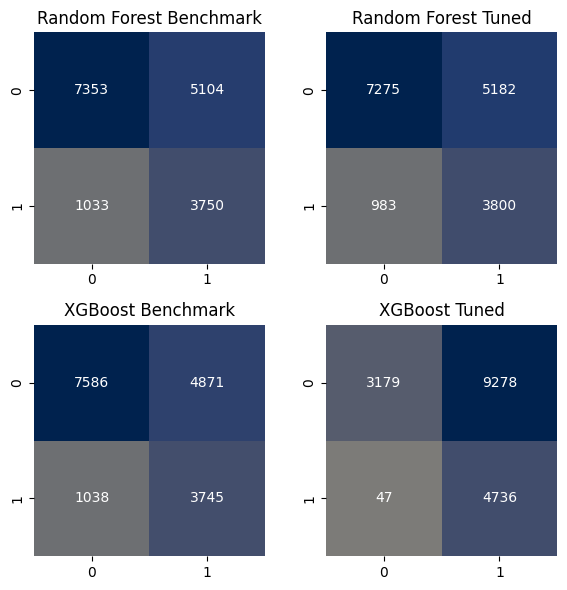

In [154]:
# plot confussion matrix serta perbandingan hasil benchmark dan tuning
list_name = []
list_recall_score_tuned = []

fig, axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, (name, algorithm) in zip(axes.flatten(), model_tuned):
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    scoring = recall_score(y_test, y_pred)
    
    ax.set_title(name)
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot = True,
        center = 0,
        fmt = "g",
        square = True,
        cmap = "cividis_r",
        cbar = False,
        ax = ax
    )

    list_name.append(name)
    list_recall_score_tuned.append(round(scoring, 3))

plt.tight_layout()
plt.show()

In [155]:
df_predict_result = pd.DataFrame({
    "Model" : list_name,
    "Recall Score" : list_recall_score_tuned
})
df_predict_result

,Model,Recall Score
0,Random Forest Benchmark,0.784
1,Random Forest Tuned,0.794
2,XGBoost Benchmark,0.783
3,XGBoost Tuned,0.990


Setelah melakukan *tuning*, pemodelan tetap menghasilkan **XGBoost** sebagai *best model* untuk *dataset* ini. Oleh karena itu, kita akan putuskan untuk memakai model **XGBoost** ini sebagai model *machine learning* yang akan digunakan untuk proses-proses selanjutnya.

### **Penjelasan tentang XGBoost**

Metode ini basisnya dari Decision Tree yang menghitung nilai similarity nilai gain sehingga penentuan suatu pohon terhadap residual. Metode ini bekerja dengan cara menggabungkan beberapa model prediksi sederhana, yang disebut “weak learner”, untuk membentuk model yang lebih kompleks dan efektif. Pada dasarnya, eXtreme Gradient Boosting bekerja dengan mengoreksi residual dari weak learner sebelumnya. Setiap iterasi dalam Gradient Boosting meningkatkan performa model secara bertahap. Hal ini karena setiap weak learner yang ditambahkan berfokus pada kesalahan yang belum dapat dikoreksi oleh weak learner sebelumnya.

Fungsi tujuan : mengoptimalkan nilai regularisasi dan membantu dalam menimalkan kesalahan prediksi dan menghindari overfitting

![WhatsApp Image 2024-02-13 at 23.32.27.jpeg](<attachment:WhatsApp Image 2024-02-13 at 23.32.27.jpeg>)
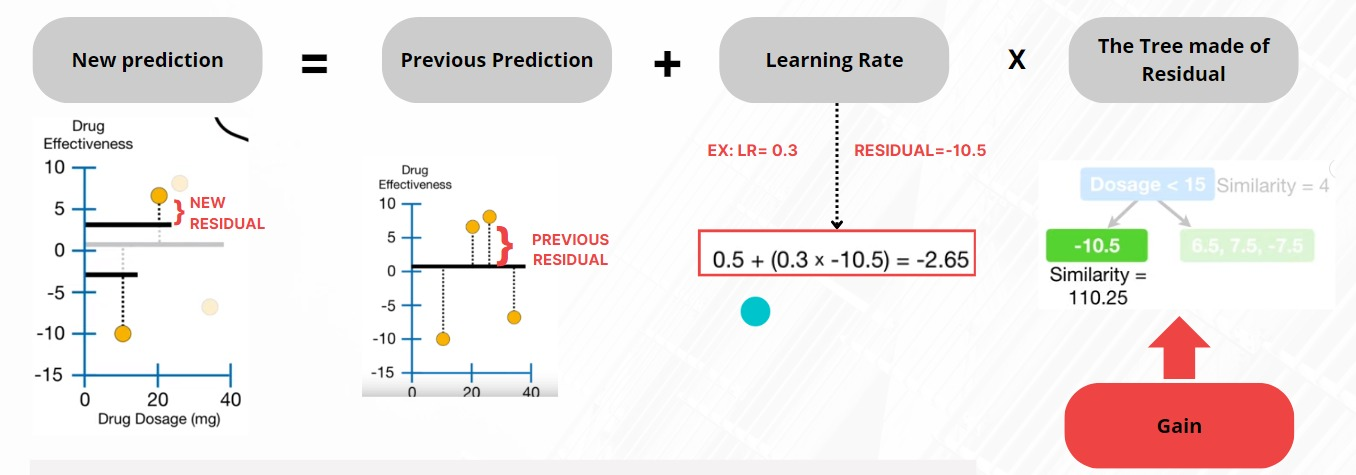

### `Model Properties`

Sekarang, kita akan coba lihat *feature* yang berpengaruh besar terhadap model dengan melakukan 2 analisis, pertama yaitu dengan melihat *feature importances*, kedua dengan melihat SHAP.

In [157]:
# menyimpan model terbaik
final_model = xgboost_tuning.best_estimator_

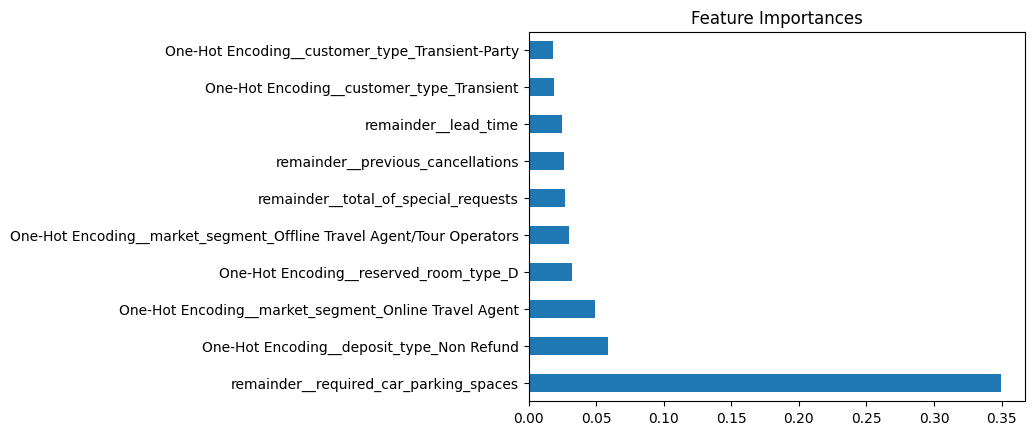

In [190]:
# menampilkan feature importances
coef1 = pd.Series(final_model["algorithm"].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind = "barh", title = "Feature Importances")
plt.show()

Terlihat bahwa untuk model XGBoost ada beberapa fitur/kolom yang paling penting diantaranya ⁠ required_car_parking_spaces ⁠, ⁠ deposit_type ⁠, ⁠ market_segment ⁠. Hal ini cukup sesuai dengan sebagian EDA yang kami analisis, ketiga fitur tersebut memang memiliki hunbungan dengan target seperti: 
- `⁠required_car_parking_spaces` : fitur ini paling berpengaruh namun tidak terlalu sesuai dengan analisis. pada fitur importance target akan melakukan cancel pada saat nilsinya 0
- `⁠deposit_type` : target cenderung akan cancel jika deposit typenya non refund
- `⁠Market Segment` : target cenderung akan melakukan cancel pada market segment Online Travel Agent

In [166]:
# membuat data train yang dipreprocessing menggunakan onehot dan scaler
X_train_encod = final_model[:-1].fit_transform(X_train)

In [167]:
# membuat nama kolom
onehot_feature = list(final_model[0].transformers_[0][1].get_feature_names_out())
remainder_feature = list(X_train.columns[final_model[0].transformers_[1][2]])
feature_names = onehot_feature + remainder_feature

100%|===================| 68954/68959 [08:16<00:00]        

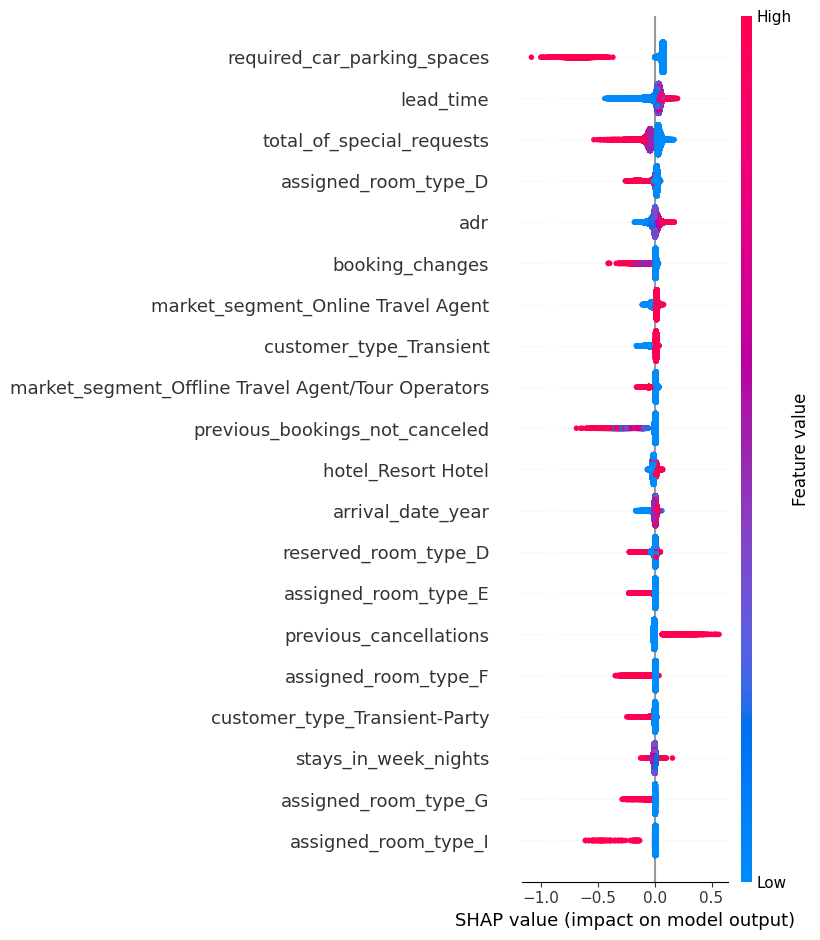

In [168]:
# menampilkan SHAP
shap_values = shap.TreeExplainer(final_model[-1],                                          
                                 data = X_train_encod,                                    
                                 feature_dependence = "independent",
                                 model_output = "probability").shap_values(X_train_encod)
                                 
shap.summary_plot(shap_values, X_train_encod, feature_names = feature_names)

Berdasarkan SHAP value, kita melihat beberapa fitur yang penting diantaranya: 
- `required_car_parking_spaces`: pemesan kamar hotel yang tidak meminta kebutuhan lahan parking memiliki kesempatan melakukan pembatalan lebih tinggi. sedangkan customer yang meminta lahan parkir mobil semakin banyak akan semakin kecil kemungkinannya melakukan pembatalan hotel
- `lead_time`: customer hotel yang melakukan booking dengan jeda waktu yang lama akan semakin besar potensi melakukan pembatalan booking hotel
- `total_of_special_request`: semakin sedikit permintan spesial dari customer terhadap penyedia hotel semakin tinggi kemungkinan customer tersebut melakukan pembatalan booking. jika semakin banyak - permintaan spesial dari customer maka semakin kecil kemungkinan customer tersebut melakukan pembatalan booking hotel
- `assigned_room_type_D`: customer yang mendapatkan kamar type D dari penyedia hotel memiliki kemungkinan semakin kecil untuk melakukan pembatalan booking
- `adr`: transaksi dengan adr semakin besar memiliki kecenderungan untuk melakukan pembatalan hotel semakin tinggi dan semakin kecil biaya adr pada transaksi tersebut semakin kecil pula kecenderungan untuk melakukan pembatalan booking
- `booking_change`: semakin banyak customer melakukan booking change maka semakin kecil kemungkinan customer tersebut melakukan pembatalan pemesanan
- `market_segment_OnlineTravelAgent`: customer yang tidak menggunakan Online Travel Agent memiliki sedikit kemungkinan semakin kecil melakukan pembatalan pemesanan
- `customer_type_transient`: Customer yang bukan merupakan type transient cenderung akan lebih kecil kemungkinannya melakukan pembatalan pemesanan hotel

Dari interpretasi SHAP Value diatas memiliki hasil yang cukup sesuai dengan hasil analisa kami pada bagian Data Analisis

### `Predict Probability vs. Actual`

In [179]:
# pengelompokan kelas probabilitas
def proba_range(data):
    if data <= 0.1:
        return "0 - 0.1"
    elif data <= 0.2:
        return "0.1 - 0.2"
    elif data <= 0.3:
        return "0.2 - 0.3"
    elif data <= 0.4:
        return "0.3 - 0.4"
    elif data <= 0.5:
        return "0.4 - 0.5"
    elif data <= 0.6:
        return "0.5 - 0.6"
    elif data <= 0.7:
        return "0.6 - 0.7"
    elif data <= 0.8:
        return "0.7 - 0.8"
    elif data <= 0.9:
        return "0.8 - 0.9"
    elif data <= 1:
        return "0.9 - 1"

In [180]:
# fitting best model
final_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One-Hot Encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('algorithm',
                 XGBClassifier(base_score=None, booster=None, cal...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=300, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=3,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=434,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [181]:
# mengambil data y_pred dan y_pred proba untuk data test
y_pred_proba_xgboost = final_model.predict_proba(X_test)[:,-1]
y_pred_xgboost = final_model.predict(X_test)

In [182]:
# pembuatan dataset baru dan memasukkan kolom y_pred_proba_xgboost dan probability_range
df_proba = X_test.copy()
df_proba["pred_probability"] = y_pred_proba_xgboost
df_proba["actual"] = y_test
df_proba["probability_range"] = df_proba["pred_probability"].apply(proba_range)
df_proba

,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,pred_probability,actual,probability_range
37931,City Hotel,86,2016,March,2,2,2,0,0,Bed and Breakfast,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,0,Transient-Party,73.95,0,0,0.926068,0,0.9 - 1
28513,Resort Hotel,159,2017,March,6,15,2,0,0,Half Board,Offline Travel Agent/Tour Operators,Travel Agent/Tour Operators,0,0,0,E,E,0,No Deposit,0,Transient,68.40,0,1,0.820931,0,0.8 - 0.9
36539,City Hotel,2,2016,January,2,2,2,0,0,Bed and Breakfast,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,D,D,0,No Deposit,0,Transient,79.60,0,0,0.843252,0,0.8 - 0.9
75537,City Hotel,261,2017,February,0,3,3,0,0,Bed and Breakfast,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,D,0,No Deposit,0,Transient,88.01,0,1,0.842256,0,0.8 - 0.9
60638,City Hotel,110,2016,May,1,2,2,1,0,Self Catering,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,D,0,No Deposit,0,Transient,68.04,0,1,0.341926,0,0.3 - 0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75967,City Hotel,104,2017,March,1,2,3,0,0,Bed and Breakfast,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,D,D,0,No Deposit,0,Transient,151.20,1,2,0.001519,0,0 - 0.1
46422,City Hotel,14,2017,March,0,4,2,0,0,Self Catering,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,0,Transient,74.80,0,0,0.957310,1,0.9 - 1
50850,City Hotel,93,2017,July,4,10,2,0,0,Bed and Breakfast,Direct,Direct,0,0,0,D,D,0,No Deposit,0,Transient,112.50,0,1,0.918628,1,0.9 - 1
83169,City Hotel,206,2017,July,2,0,2,0,0,Self Catering,Online Travel Agent,Travel Agent/Tour Operators,0,0,0,A,A,0,No Deposit,0,Transient,89.10,0,2,0.940209,0,0.9 - 1


In [183]:
df_proba.groupby("probability_range")[["actual", "pred_probability"]].mean()

,actual,pred_probability
probability_range,,
0 - 0.1,0.001229,0.006910
0.1 - 0.2,0.020492,0.148278
0.2 - 0.3,0.022013,0.253485
0.3 - 0.4,0.025172,0.352131
0.4 - 0.5,0.036728,0.453083
0.5 - 0.6,0.042373,0.554491
0.6 - 0.7,0.061350,0.654381
0.7 - 0.8,0.085834,0.754647
0.8 - 0.9,0.188692,0.856606


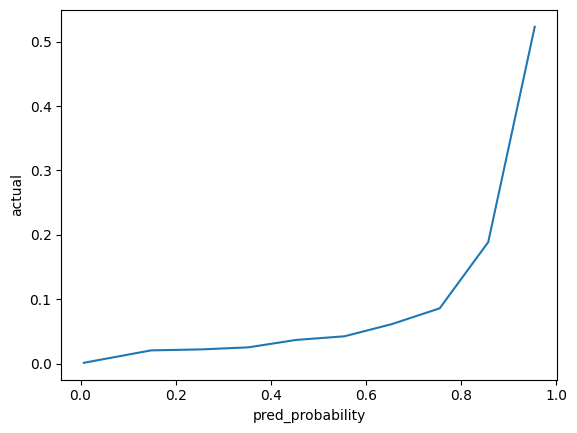

In [188]:
sns.lineplot(df_proba.groupby("probability_range")[["actual", "pred_probability"]].mean(), y = "actual", x = "pred_probability")
plt.show()

Kita bisa menyimpulkan bahwa model dapat bekerja lebih baik jika nilai probabilitasnya ada di bawah 0,5. Sedangkan di atas itu, model masih belum bisa bekerja dengan baik.

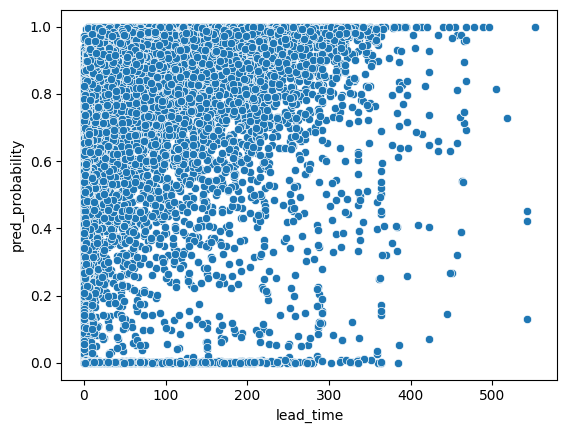

In [193]:
sns.scatterplot(df_proba, y = "pred_probability", x = "lead_time")
plt.show()

Dari scatterplot di atas kita bisa melihat pola bahwa semakin lama lead_time, semakin tinggi probabilitas customeruntuk melakukan cancel

## **CONCLUSION AND RECOMMENDATION**

### `Conclusion`

Berdasarakan analisis dan penegmbangan model yang telah dilakukan, model prediktif yang mampu mengidentifikasi customer yang memiliki potensi melakukan cancel didapat menggunakan algoritma XGBoost dengan parameter Scale_post_weight. Parameter ini digunakan untuk imbalance data. Hyperparameter tuning dilakukan untuk mendapatkan nilai metriks evaluasi yang maksimal. Model XGBoost memiliki score Recall sebesar 99% yang artinya bahwa model mampu mengidentifikasi dan menangkap data yang memiliki potensi pembatalan booking hotel dengan baik sesuai dengan tujuan penelitian yang dilakukan. Model ini dapat digunakan dalam sektor perhotelan. Model dapat digambarkan secara cost analysis sebagai berikut:

Berdasarkan Asumsi yang dibuat:
- Harga rata-rata kamar hotel : 91.85 Euro
- Biaya Strategi Retensi : 10% x 91.85 Euro = 9.18 Euro

Asumsikan apabila terdapat 500 pemesanaan hotel dalam waktu tertentu:

Tanpa Model Prediksi:
Dari dataset yang telah dilakukan prediksi bahwa tingkat pembatalan pemesanan pada hotel secara total adalah sebesar 27%

- Jumlah pemesanan x Harga rata-rata kamar hotel x (1-Tingkat Cancel)
- = 500 pemesanan x 91.85 euro (1-27%)
- = 500 x 67.050
- = 33525.25 Euro

Setelah melakukan pengembangan model didapatkan data customer yang diprediksi tepat membatalkan pemesanan adalah 34% yang diasumsikan melanjutkan pemesanan karena dilakukannya strategi retensi, dan terdapat customer yang aktualnya tidak cancel namun diprediksi melakukan cancel sebanyak 74% sehingga tidak ada startegi retensi yang mengakibatkan tetap lanjut melakukan cancel sehingga hotel harus menanggung kerugian sebesar harga per malam.

- Jumlah pemesanan x Harga rata-rata kamar hotel x (1-Tingkat Cancel)
- = 500 pemesanan x 91.85 euro (1-74%)
- = 500 x 23.88
- = 11940.5 Euro

Sehingga perbandingan sebagai berikut:
- Potensi kerugian yang harus ditanggung oleh hotel tanpa model yaitu 33525.25 Euro
- Potensi kerugian yang harus ditanggung oleh hotel dengan menggunakan model yaitu 11940.5 Euro

Sehingga dalam hal ini hotel dapat mengurangi resiko kerugian sebesar 47.47%. Dalam kata lain dapat dikatakan model dapat membantu hotel untuk memprediksi customer yang memiliki potensi melakukan cancel.

### `Recommendation`

- Berdasarkan jeda waktu pemesan terhadap kedatangan booking kami merekomendasikan untuk pihak hotel membatasi waktu pemesanan ke waktu check in maksimal tidak lebih dari setahun 
- Menerapkan sistem reschedule/refund terhadap customer dengan maksimal hari pengajuan, dan memberikan kebijakan proporsional penalty terhadap customer yang melakukan cancellation mendekati waktu check in
- Hotel dapat meningkatkan pemesanan booking pada saat winter dan mengurangi pembatalan pemesanan booking pada saat summer season yang merupakan high season dengan memberikan penawaran ulang yang lebih menarik pada calon customer seperti memberikan voucher discount
- Merekomendasikan tim marketing untuk memberikan penawaran menarik berupa promosi free sarapan untuk pemesan self catering yang melakukan cancel
- Tim penyedia layanan hotel untuk menawarkan kebutuhan special request kepada pemesan yang tidak melakukan special request terlebih dahulu
- Membuat paket promo seperti iklan yang ditargetkan kepada akun sosial media pribadi berupa promo liburan atau promo akhir pekan dengan target audience type customer transient karena customer dengan type transient paling banyak melakukan pembatalan hotel, customer tersebut banyak melakukan pemesanan pada saat weekend sehingga kami merekomendasikan promo akhir pekan
- Menerapkan sistem reservasi pusat (CRS) untuk memeinimalisir ketidaksesuaian kamar dengan mengelola sistem ketersediaan kamar
- Menerapkan sistem deposit dan reschedule sebagai pertimbangan customer melakukan cancellation
- Memperbaiki pengelolaan di musim liburan atau pada high season
- Mengelola kebijakan pembatalan

### **MODEL LIMITATION**

Model ini hanya dapat digunakan pada rentang data yang digunakan pada pemodelan ini yaitu :

| Feature | Data Type | Limitasi |
| --- | --- | --- |
| `lead_time` | Integer | Jarak hari antara tanggal *booking* hotel hingga tanggal yang dijadwalkan untuk *check-in* di rentang 0-709 |
| `arrival_date_year` | Integer | Tahun dijadwalkan *check-in* di rentang 2015-2017 |
| `stays_in_weekend_nights` | Integer | Jumlah malam di akhir pekan (Sabtu atau Minggu) yang di-*booking* di rentang 0-19 |
| `stays_in_week_nights` | Integer | Jumlah malam dalam seminggu (Senin - Jum'at) yang di-*booking* di rentang 0-50 |
| `adults` | Integer | Jumlah orang dewasa di rentang 0-4 |
| `children` | Float | Jumlah anak-anak di rentang 0-10 |
| `babies` | Integer | Jumlah bayi di rentang 0-2 |
| `is_repeated_guest` | Integer | Nilai yang berasal dari pemesan yang berulang atau tidak di rentang 0-1 |
| `previous_cancellations` | Integer | Jumlah Pemesanan yang dibatalkan sebelumnya di rentang 0-26 |
| `previous_bookings_not_canceled` | Integer | Jumlah *booking* hotel sebelumnya yang tidak dibatalkan di rentang 0-72 |
| `booking_changes` | Integer | Jumlah perubahan yang dilakukan pada *booking* hotel di rentang 0-18 |
| `days_in_waiting_list` | Integer | Jumlah hari untuk setiap *booking* hotel yang masuk ke dalam *waiting list* di rentang 0-391 |
| `adr` | Float | Rata-rata tarif harian atau *Average Daily Rate* di rentang 0-510 |
| `required_car_parking_spaces` | Integer | Jumlah ruang parkir mobil yang dibutuhkan pemesan di rentang 0-3 |
| `total_of_special_requests` | Integer | Jumlah permintaan khusus yang dibuat oleh pemesan di rentang 0-5 |

**SAVE MODEL**

In [195]:
final_model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One-Hot Encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('algorithm',
                 XGBClassifier(base_score=None, booster=None, cal...
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=300, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=3,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=434,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [196]:
pickle.dump(final_model, open("final_model_for_hotel_booking_demand.sav", "wb"))

**LOAD MODEL**

In [197]:
model_loaded = pickle.load(open('final_model_for_hotel_booking_demand.sav','rb'))

**PREDICT MODEL**

In [201]:
df_test_1 = pd.DataFrame({
    "hotel" : ["City Hotel"], 
    "lead_time" : [69], 
    "arrival_date_year" : [2015], 
    "arrival_date_month" : ["January"], 
    "stays_in_weekend_nights" : [2], 
    "stays_in_week_nights" : [10], 
    "adults" : [2],
    "children" : [1], 
    "babies" : [0], 
    "meal" : ["Half Board"], 
    "market_segment" : ["Direct"], 
    "distribution_channel" : ["Corporate"], 
    "is_repeated_guest" : [0],
    "previous_cancellations" : [1], 
    "previous_bookings_not_canceled" : [2], 
    "reserved_room_type" : ["A"], 
    "assigned_room_type" : ["A"],
    "booking_changes" : [4],
    "deposit_type" : ["No Deposit"],
    "days_in_waiting_list" : [2],
    "customer_type" : ["Transient"],
    "adr" : [169],
    "required_car_parking_spaces" : [2],
    "total_of_special_requests" : [4]
})

# print sample data
display(df_test_1)

# predict that data
print("Predict proba: ",model_loaded.predict_proba(df_test_1))
print("Predict range: ",model_loaded.predict(df_test_1))

,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,City Hotel,69,2015,January,2,10,2,1,0,Half Board,Direct,Corporate,0,1,2,A,A,4,No Deposit,2,Transient,169,2,4


Predict proba:  [[9.990100e-01 9.899829e-04]]
Predict range:  [0]


In [205]:
df_test_2 = pd.DataFrame({
    "hotel" : ["Resort Hotel"], 
    "lead_time" : [9], 
    "arrival_date_year" : [2016], 
    "arrival_date_month" : ["August"], 
    "stays_in_weekend_nights" : [2], 
    "stays_in_week_nights" : [10], 
    "adults" : [5],
    "children" : [0], 
    "babies" : [0], 
    "meal" : ["Bed and Breakfast"], 
    "market_segment" : ["Direct"], 
    "distribution_channel" : ["Travel Agent/Tour Operators"], 
    "is_repeated_guest" : [0],
    "previous_cancellations" : [1], 
    "previous_bookings_not_canceled" : [2], 
    "reserved_room_type" : ["A"], 
    "assigned_room_type" : ["D"],
    "booking_changes" : [4],
    "deposit_type" : ["No Deposit"],
    "days_in_waiting_list" : [2],
    "customer_type" : ["Transient-Party"],
    "adr" : [169],
    "required_car_parking_spaces" : [2],
    "total_of_special_requests" : [4]
})

# print sample data
display(df_test_2)

# predict that data
print("Predict proba: ",model_loaded.predict_proba(df_test_2))
print("Predict range: ",model_loaded.predict(df_test_2))

,hotel,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,9,2016,August,2,10,5,0,0,Bed and Breakfast,Direct,Travel Agent/Tour Operators,0,1,2,A,D,4,No Deposit,2,Transient-Party,169,2,4


Predict proba:  [[9.9963188e-01 3.6811468e-04]]
Predict range:  [0]
